### Different groups

1. No true oscillation                                                  
                (CF == nan)

2. True oscillation but no sig. PAC                                    
                (pac_presence == 0)

3. True oscillation but no sig. PAC after resampling                    
                (pac_presence == 1 & resamp_pac_presence == 0)

4. sig. PAC                                                              
                (resamp_pac_presence == 1)


### Two Kinds of sig. PAC

1. True interactions between oscillators

2. PAC caused by the transformation of non-sinusoidal features of a signal

### Features

The features we extracted can be split up in three categories:

1. PAC values:    
                 Rho value & resampled Z-value 

2. PSD parameters extracted with FoooF:    
                 Aperiodic & periodic components  

3. Non-sinusoidal components extracted with ByCycle:   
                 Symmetry measures & peak voltage

### Imports and load data

In [1]:
# This magic command plots figures directly in the notebook
%matplotlib inline
# This sets a higher resolution for figures
%config InlineBackend.figure_format = 'retina'

import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn import metrics 
from scipy.spatial.distance import cdist 


import mglearn

C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('datastruct_full.npy',  allow_pickle=True)

# dataframe
features_df = pd.read_csv('features_df_epoch_4_12.csv', sep=',')

### Correlation Matrix

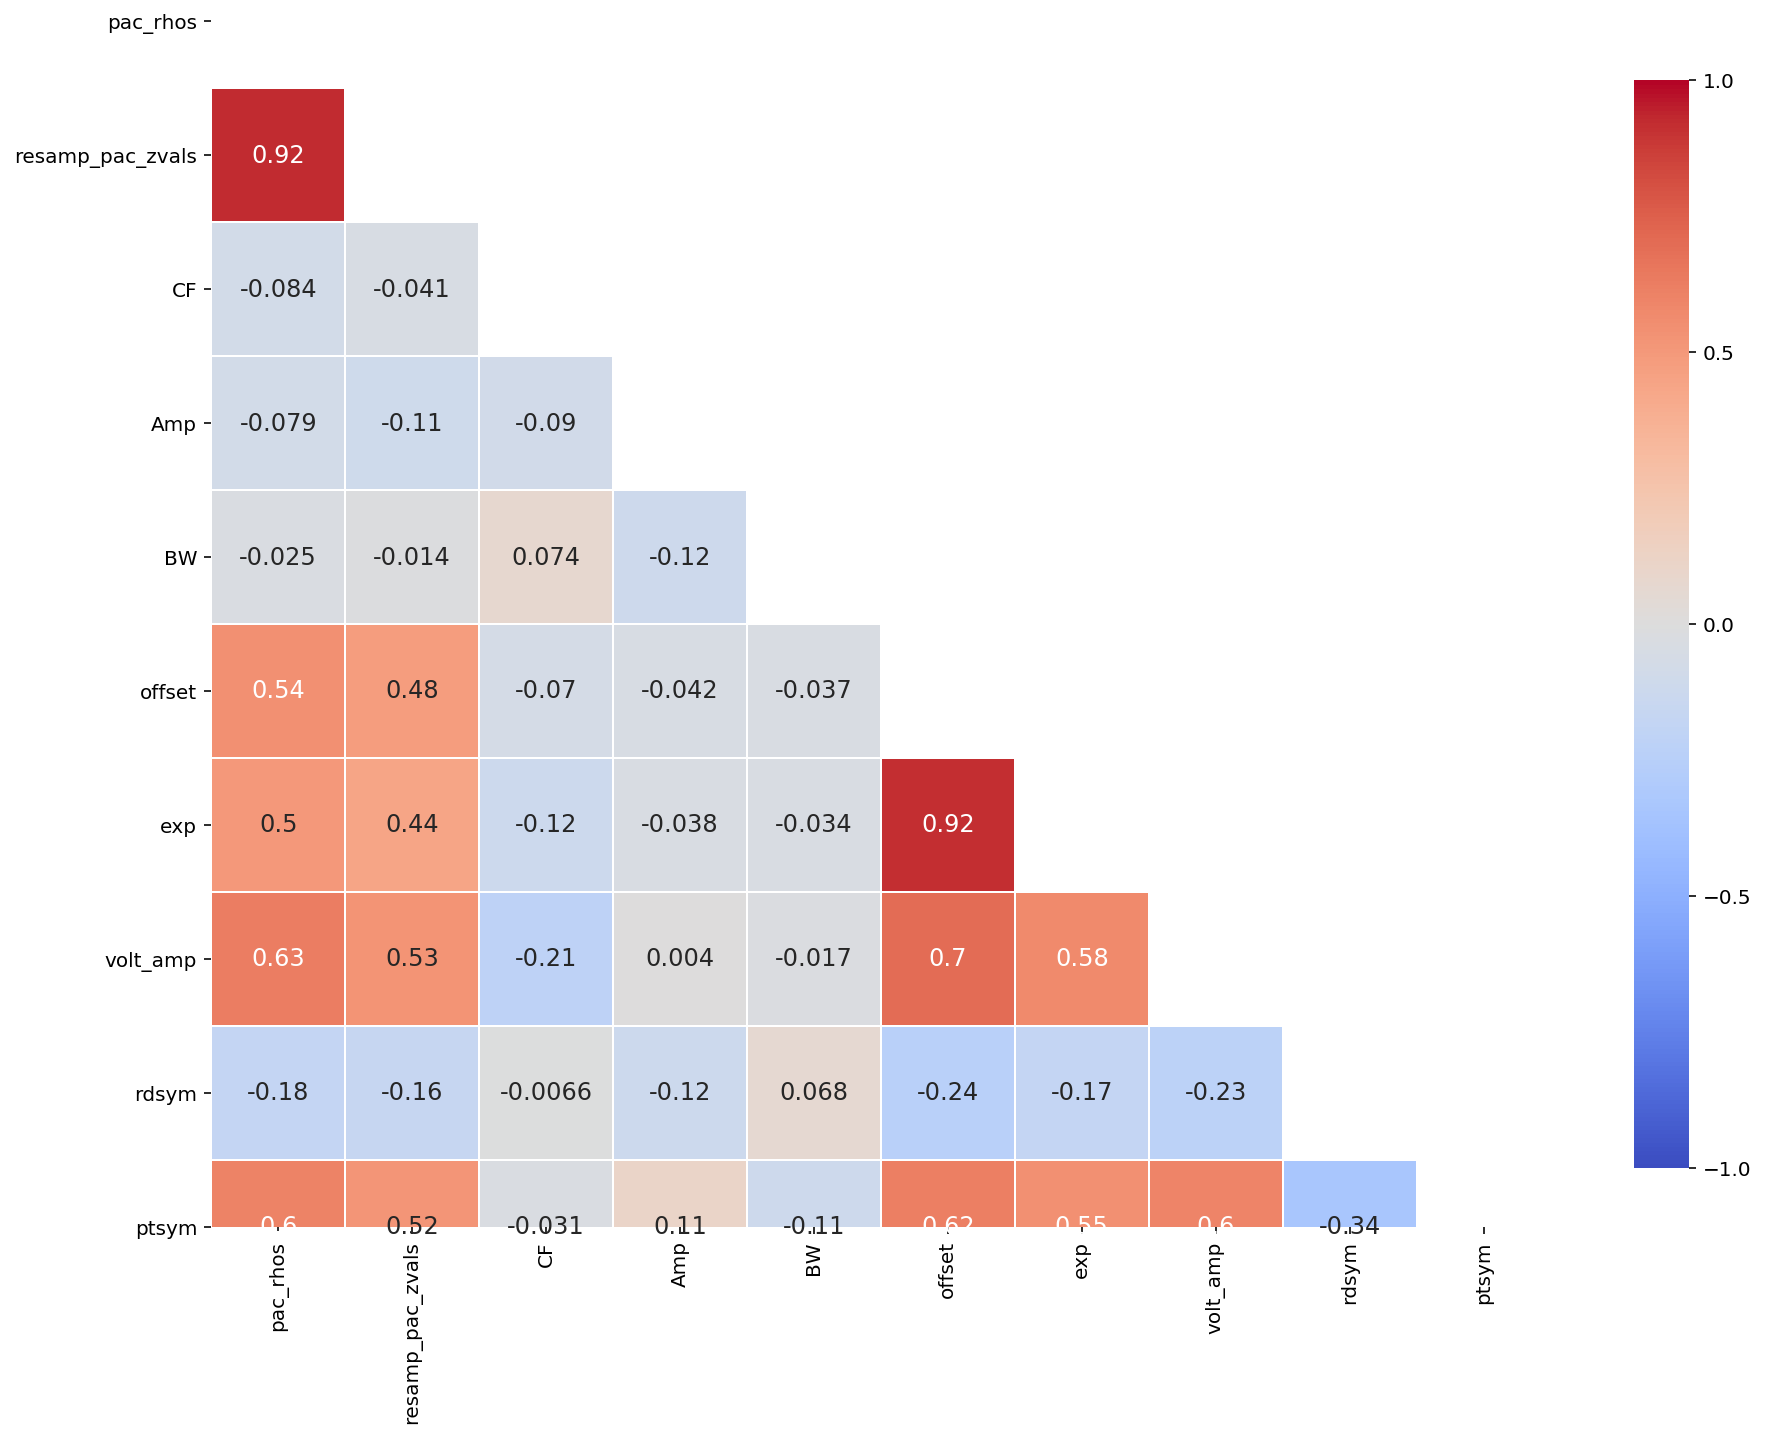

In [3]:
#### first create new dataframe with only the features we want to plot
corr_features_df = features_df[['pac_rhos', 'resamp_pac_zvals','CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym']].copy()

corr_matrix = corr_features_df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

 <div class="alert alert-danger">
Both measures of the PAC value and two of the background parameters correlate too much with each other, so we standardize them and add them.
</div>

In [4]:
# change to right shape for sklearn

# change shape of the PAC measurements
pac_rhos = np.reshape(features_df[['pac_rhos']].copy(), [len(features_df['pac_rhos']), 1])
resamp_pac_zvals = np.reshape(features_df[['resamp_pac_zvals']].copy(), [len(features_df['resamp_pac_zvals']), 1])

# change shape of the aperiodic slope measurement
offset = np.reshape(features_df[['offset']].copy(), [len(features_df['offset']), 1])
exp = np.reshape(features_df[['exp']].copy(), [len(features_df['exp']), 1])

# change shape of the aperiodic slope measurement
offset_long = np.reshape(features_df[['offset_long']].copy(), [len(features_df['offset_long']), 1])
exp_long = np.reshape(features_df[['exp_long']].copy(), [len(features_df['exp_long']), 1])

# first scale both data and then add them

# for PAC values
scaler = StandardScaler()
pac_values = scaler.fit_transform(pac_rhos) + scaler.fit_transform(resamp_pac_zvals)

# for slope
slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

# for slope (long measure)
slope_long = scaler.fit_transform(offset_long) + scaler.fit_transform(exp_long)

# write all three new features to the features_df 
features_df['pac_values'] = pac_values
features_df['slope'] = slope
features_df['slope_long'] = slope_long

In [5]:
# first drop all nan's (which are the channels with no true low-frequency oscillation)
features_df_nonan = features_df.dropna()

# then only select the channels that have sig. PAC after resampling
features_df_pac = features_df_nonan[features_df_nonan['resamp_pac_presence']== '1']


In [6]:
# stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
cluster_features = np.hstack((
                   features_df_pac[['pac_values']].copy(), features_df_pac[['CF']].copy(), 
                   features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                   features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym']].copy(), 
                   features_df_pac[['ptsym']].copy())) 

# Scale all data 
scaler = StandardScaler()
scaler.fit(cluster_features)
X_scaled = scaler.transform(cluster_features)

# 2. Clustering with K-Means Analysis + Principal Component Analysis

Because the true and spurious PAC both have different origins (true interactions versus non-sinusoidal features), we expect these types of PAC differ on at least some of the features. Therefore, we use the unsupervised K-Means machine learning method. For visualization purposes we do a Principal Component Analysis for dimensionality reduction so we can visualize the clusters on two dimensions. 

### Validation for 2 groups

In [38]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
    kmeanModel.fit(X_scaled)     
      
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

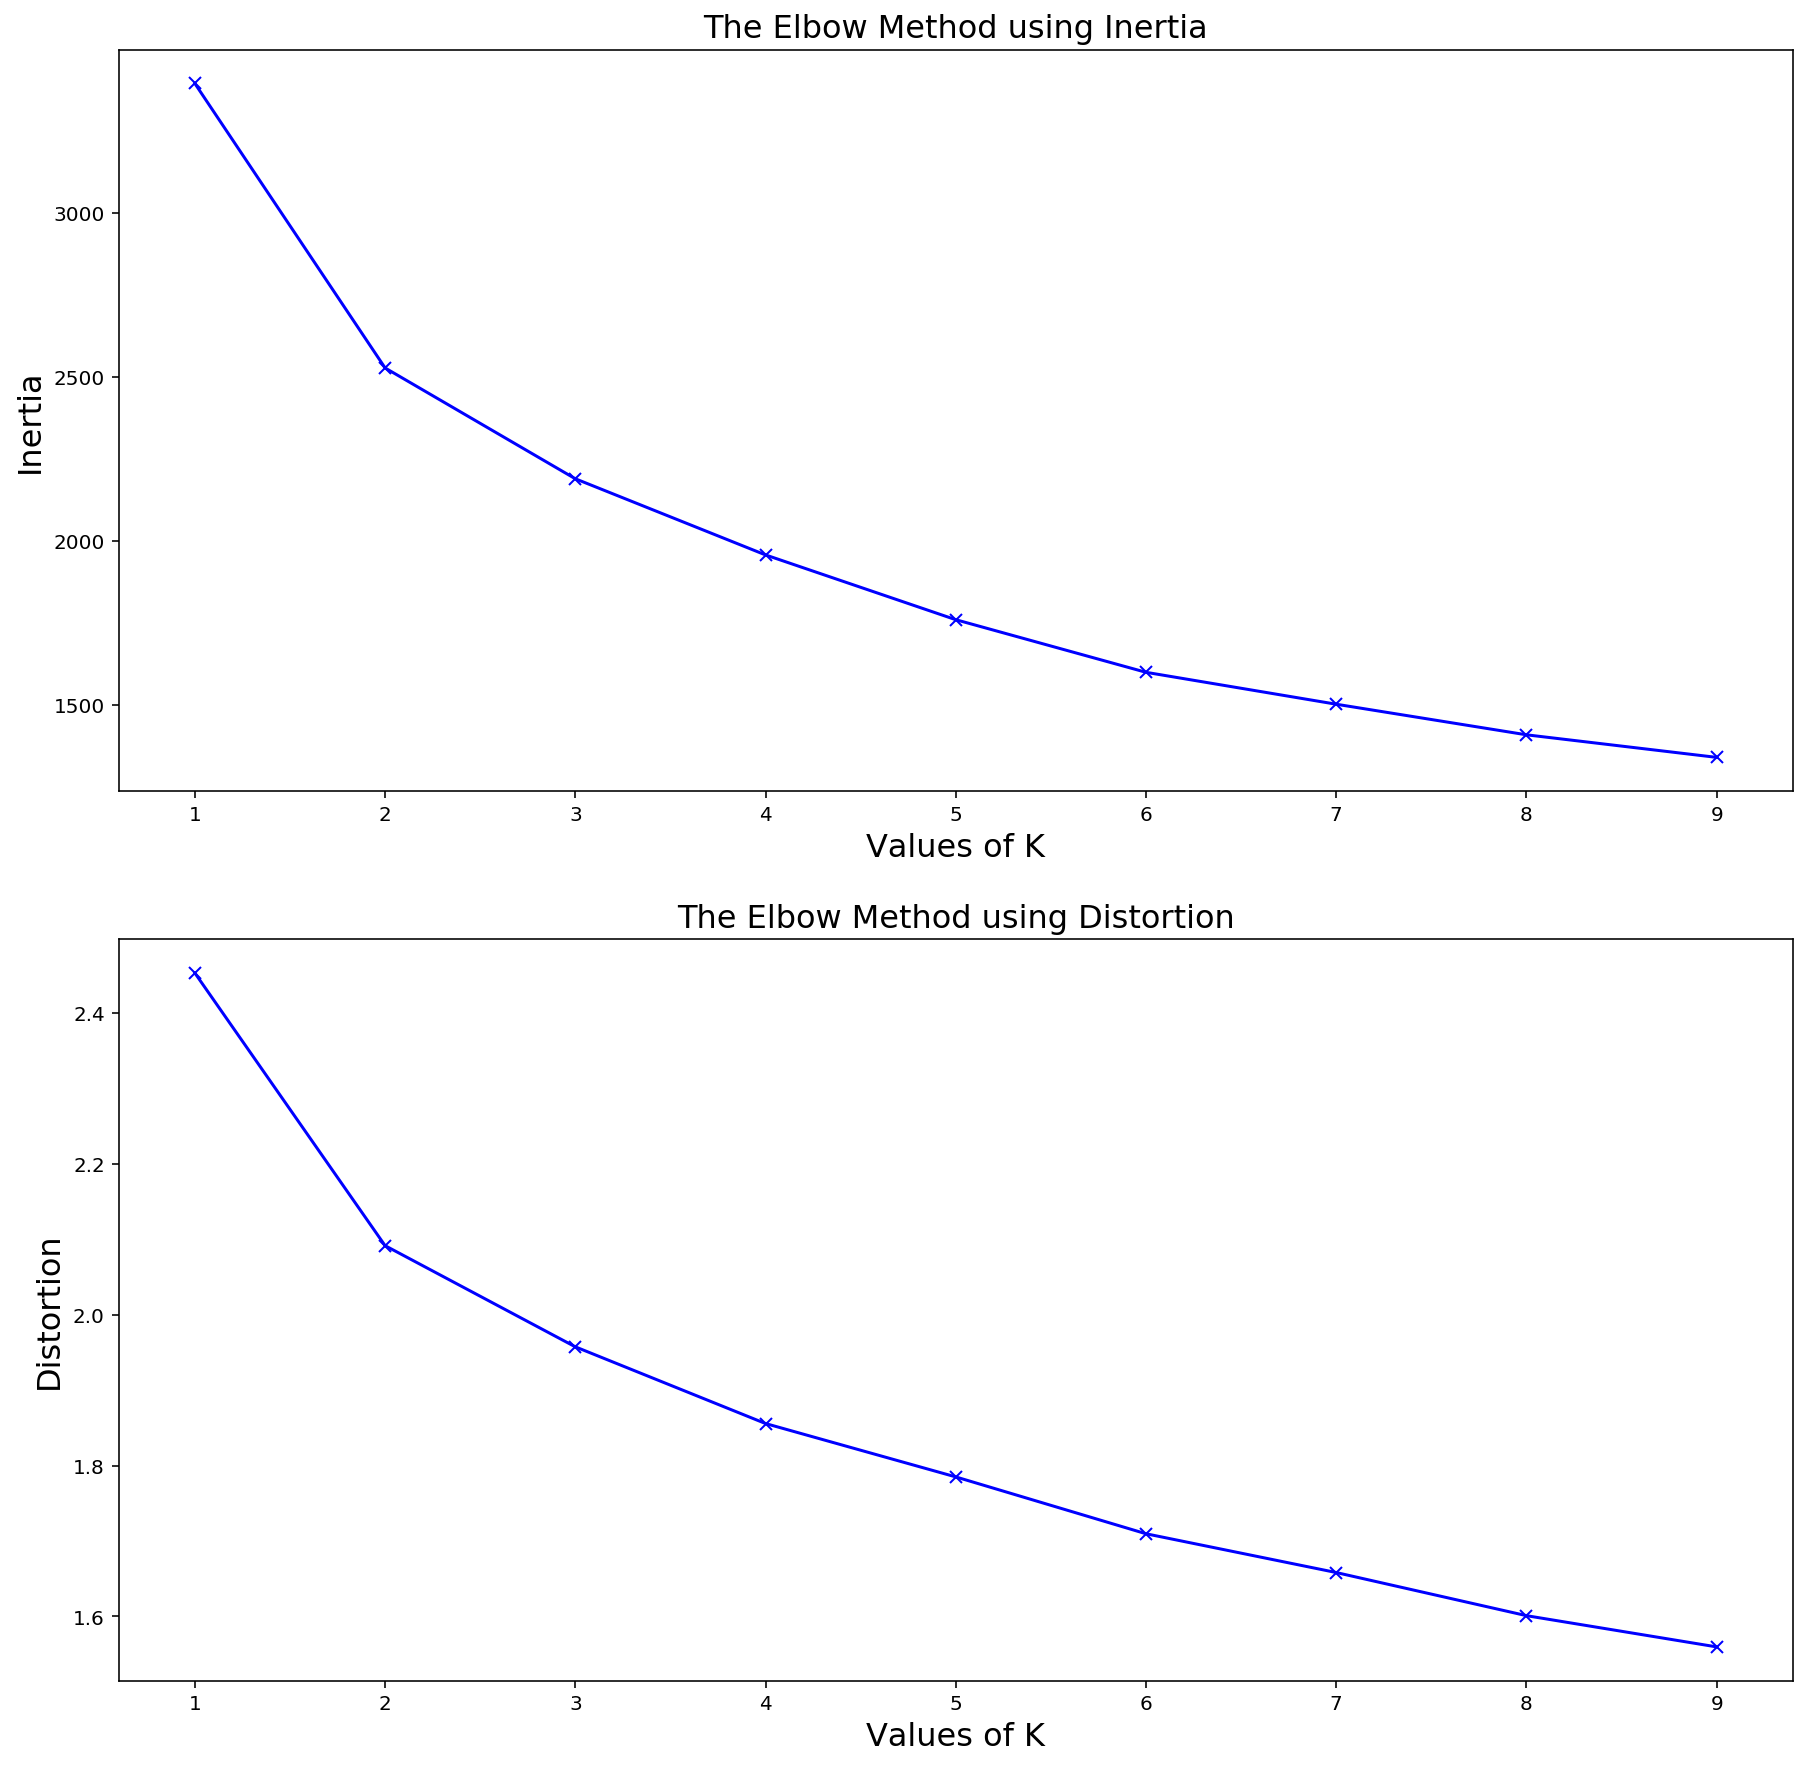

In [39]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K', size=16) 
plt.ylabel('Inertia', size=16) 
plt.title('The Elbow Method using Inertia', size=16) 

plt.subplot(2,1,2)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K', size=16) 
plt.ylabel('Distortion', size=16) 
plt.title('The Elbow Method using Distortion', size=16) 
plt.show() 

 <div class="alert alert-success">
Chose 2 clusters: True and waveform shaped PAC. Did not really find proof to choose another amount of clusters. 
</div>

### Kmeans

In [9]:
# Use K-Means to cluster into two groups
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled);

In [10]:
# Use PCA to create two components
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [11]:
# Create list with feature names for visualization 
feature_list = ['PAC values', 'PSD CF', 'PSD Amp', 'PSD BW', \
                'Volt Amp', 'RD Sym', 'PT Sym']

 <div class="alert alert-success">
 Did not use the aperiodic PSD component (slope) for the Kmeans clustering, because this is the feature I want to do regression analysis on and look at the differences between the group. If I would distinguish on the feature and later on look at the differences I think this would be double dipping. 
 </div>

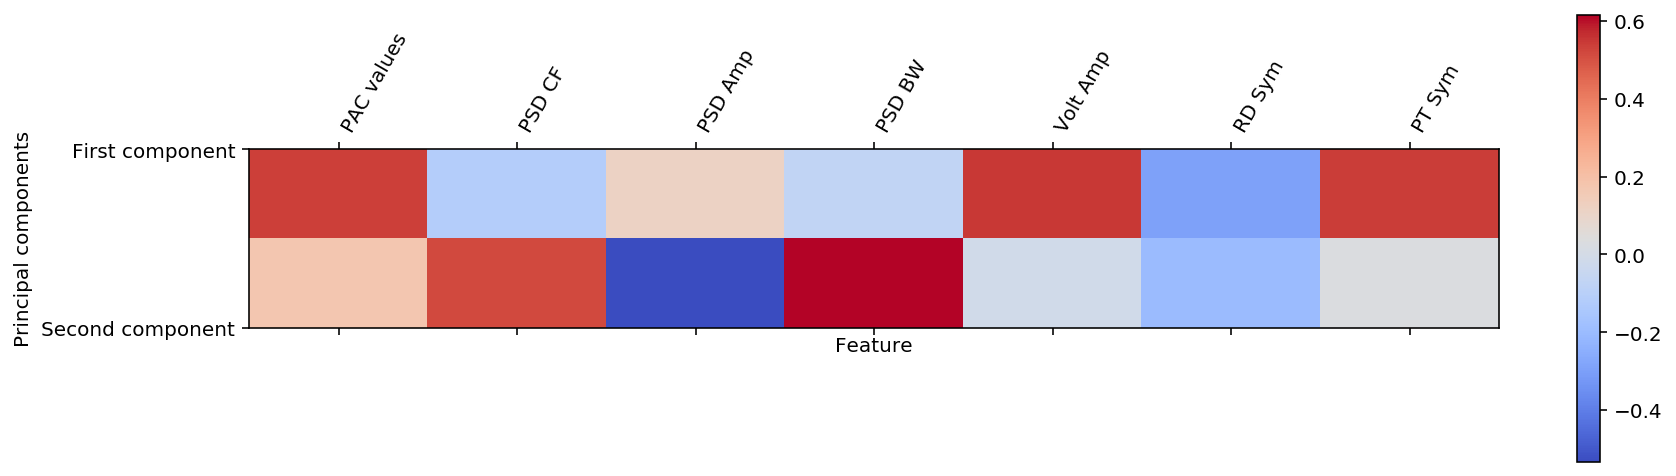

In [12]:
# Which features drive both components?
plt.matshow(pca.components_, cmap='coolwarm');
plt.yticks([0, 1], ["First component", "Second component"]);
plt.colorbar();
plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left');
plt.xlabel("Feature");
plt.ylabel("Principal components");

 <div class="alert alert-success">
Interestingly, the first component consists pac_values and symmetry measures, while the second parameter consists mostly of periodic (PSD) measures. 
</div>

Text(0, 0.5, 'Second principal component')

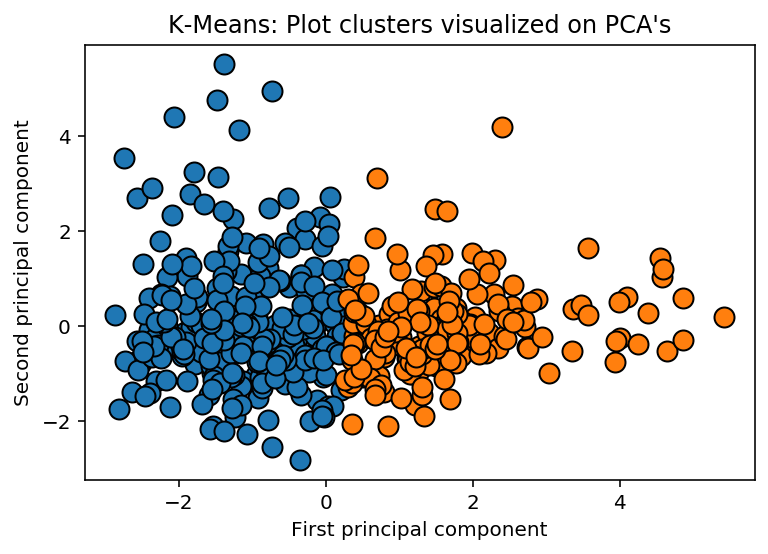

In [13]:
# visualize on PCA  
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
plt.title('K-Means: Plot clusters visualized on PCA\'s')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


### write clusters to epochs

In [14]:
# write clusters to dataframe and merge with original one
features_df_pac['Clusters'] = kmeans.labels_

pd.options.mode.chained_assignment = None
features_df = pd.merge(features_df, features_df_pac, how='outer')

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# add cluster number to the other groups as identification 

for ii in range(len(features_df)):
    
    # 11. no oscillation
    if np.isnan(features_df['CF'][ii]):
        
        features_df['Clusters'][ii] = 11
    
    # 12. true oscillation but no sig. PAC
    if (~np.isnan(features_df['CF'][ii])) & (features_df['pac_presence'][ii] == '0'):
    
        features_df['Clusters'][ii] = 12
     
    # 13. true oscillation but no sig. PAC after resampling
    if (features_df['pac_presence'][ii] == '1') & (features_df['resamp_pac_presence'][ii] == '0'):
    
        features_df['Clusters'][ii] = 13
    
        

In [16]:
pd.set_option('display.max_columns', None)
features_df[1040:1050]

,subj,ch,ep,CF,Amp,BW,offset,knee,exp,offset_long,knee_long,exp_long,pac_presence,pac_pvals,pac_rhos,resamp_pac_presence,resamp_pac_pvals,resamp_pac_zvals,volt_amp,rdsym,ptsym,pac_values,slope,slope_long,Clusters
1040,3,48,0,NaN,NaN,NaN,9.849102,2939.554906,3.903363,8.812724,157.919501,3.196788,<class 'numpy.int64'>,NaN,NaN,<class 'numpy.int64'>,NaN,NaN,NaN,NaN,NaN,NaN,2.300837,1.451742,11.0
1041,3,48,1,NaN,NaN,NaN,10.344799,5475.073277,4.181343,9.029264,213.538460,3.307425,<class 'numpy.int64'>,NaN,NaN,<class 'numpy.int64'>,NaN,NaN,NaN,NaN,NaN,NaN,2.835055,1.653776,11.0
1042,3,48,2,8.057391,0.242294,2.124418,10.213035,2928.999265,4.080654,9.785935,1053.724892,3.784041,1,0.000000e+00,0.155730,1,4.430527e-05,3.919832,7033.612518,0.502924,0.561404,4.304217,2.665715,2.443336,1.0
1043,3,48,3,11.168821,0.388776,2.121605,8.820491,198.209461,3.189230,8.190268,19.138308,2.777427,1,3.312906e-13,0.051485,0,2.330229e-01,0.728928,3691.657447,0.500000,0.523077,0.057598,1.052226,0.776894,13.0
1044,3,48,4,NaN,NaN,NaN,9.764291,1280.503160,3.851886,8.937527,173.187686,3.281805,<class 'numpy.int64'>,NaN,NaN,<class 'numpy.int64'>,NaN,NaN,NaN,NaN,NaN,NaN,2.205441,1.587918,11.0
1045,3,49,0,7.210774,0.512247,2.390788,9.647815,1660.948403,3.861682,8.540830,63.381175,3.067772,1,0.000000e+00,0.137113,1,1.774190e-05,4.135075,5101.175511,0.451923,0.613636,4.031319,2.156540,1.207260,1.0
1046,3,49,1,7.185896,0.352711,2.337851,10.421222,9581.729461,4.311614,9.107568,271.159826,3.446644,1,0.000000e+00,0.176558,1,9.349058e-06,4.279895,5174.300136,0.458015,0.594203,4.981113,3.006591,1.818962,1.0
1047,3,49,2,7.407156,0.491125,2.000000,9.636576,1377.917857,3.749579,9.185081,385.502171,3.458311,1,0.000000e+00,0.148705,1,7.175470e-05,3.802040,6417.979395,0.463771,0.573748,4.078178,2.036497,1.865339,1.0
1048,3,49,3,7.043161,0.560228,3.139659,9.266475,1817.268951,3.582639,8.204193,127.945385,2.882472,1,0.000000e+00,0.103807,1,6.058450e-04,3.236114,4445.746162,0.486667,0.563380,2.749065,1.679060,0.880825,0.0
1049,3,49,4,6.835456,0.289046,2.000000,9.373632,287.077602,3.624791,9.205584,118.772754,3.503839,1,0.000000e+00,0.185270,1,3.987705e-07,4.935968,5922.305327,0.491018,0.586466,5.576795,1.776243,1.917018,1.0


# 3. Linear Regression Models 

If these two clusters truly have different origins, but have likeawise PAC values (which is the average of the Rho value and the resampled Z value), these PAC values should arise because of different reasons. To test this, we apply linear regression models on both clusters to see whether the PAC value is predicted by different features for both clusters 

In [17]:
# create X and Y for each cluster 
X_cluster0 = np.hstack((
    features_df[features_df['Clusters'] == 0][['CF']].copy(),
    features_df[features_df['Clusters'] == 0][['Amp']].copy(),
    features_df[features_df['Clusters'] == 0][['BW']].copy(),
    features_df[features_df['Clusters'] == 0][['slope']].copy(),
    features_df[features_df['Clusters'] == 0][['volt_amp']].copy(),
    features_df[features_df['Clusters'] == 0][['rdsym']].copy(),
    features_df[features_df['Clusters'] == 0][['ptsym']].copy()))

X_cluster1 = np.hstack((
    features_df[features_df['Clusters'] == 1][['CF']].copy(),
    features_df[features_df['Clusters'] == 1][['Amp']].copy(),
    features_df[features_df['Clusters'] == 1][['BW']].copy(),
    features_df[features_df['Clusters'] == 1][['slope']].copy(),
    features_df[features_df['Clusters'] == 1][['volt_amp']].copy(),
    features_df[features_df['Clusters'] == 1][['rdsym']].copy(),
    features_df[features_df['Clusters'] == 1][['ptsym']].copy()))

Y_cluster0 = features_df[features_df['Clusters'] == 0][['pac_values']].copy()

Y_cluster1 = features_df[features_df['Clusters'] == 1][['pac_values']].copy()


In [18]:
# fit and transform
X_cluster0 = scaler.fit(X_cluster0).transform(X_cluster0)
X_cluster1 = scaler.fit(X_cluster1).transform(X_cluster1)
Y_cluster0 = scaler.fit(Y_cluster0).transform(Y_cluster0)
Y_cluster1 = scaler.fit(Y_cluster1).transform(Y_cluster1)


# regression fit
reg_cluster0 = linear_model.LinearRegression().fit(X_cluster0, Y_cluster0)
reg_cluster1 = linear_model.LinearRegression().fit(X_cluster1, Y_cluster1)

Text(0, 0.5, 'Second principal component')

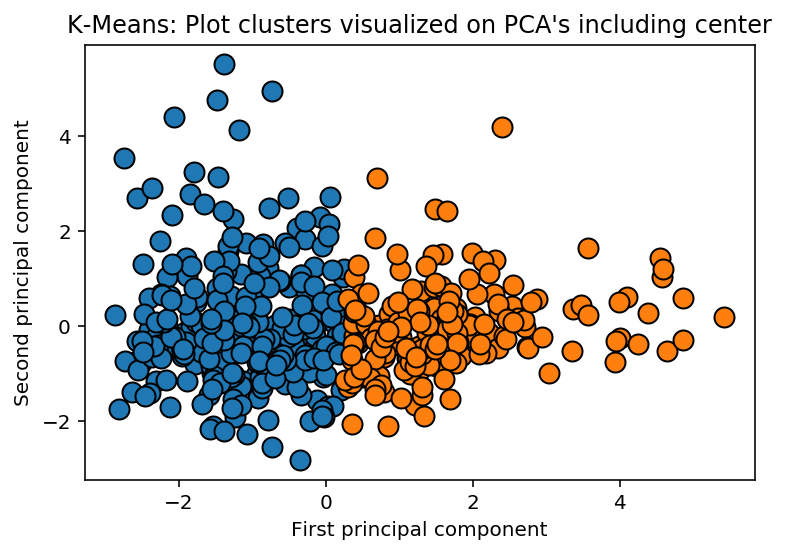

In [19]:
# Show which clustering is used for the linear models
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], kmeans.labels_, markers='o')
plt.title('K-Means: Plot clusters visualized on PCA\'s including center')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

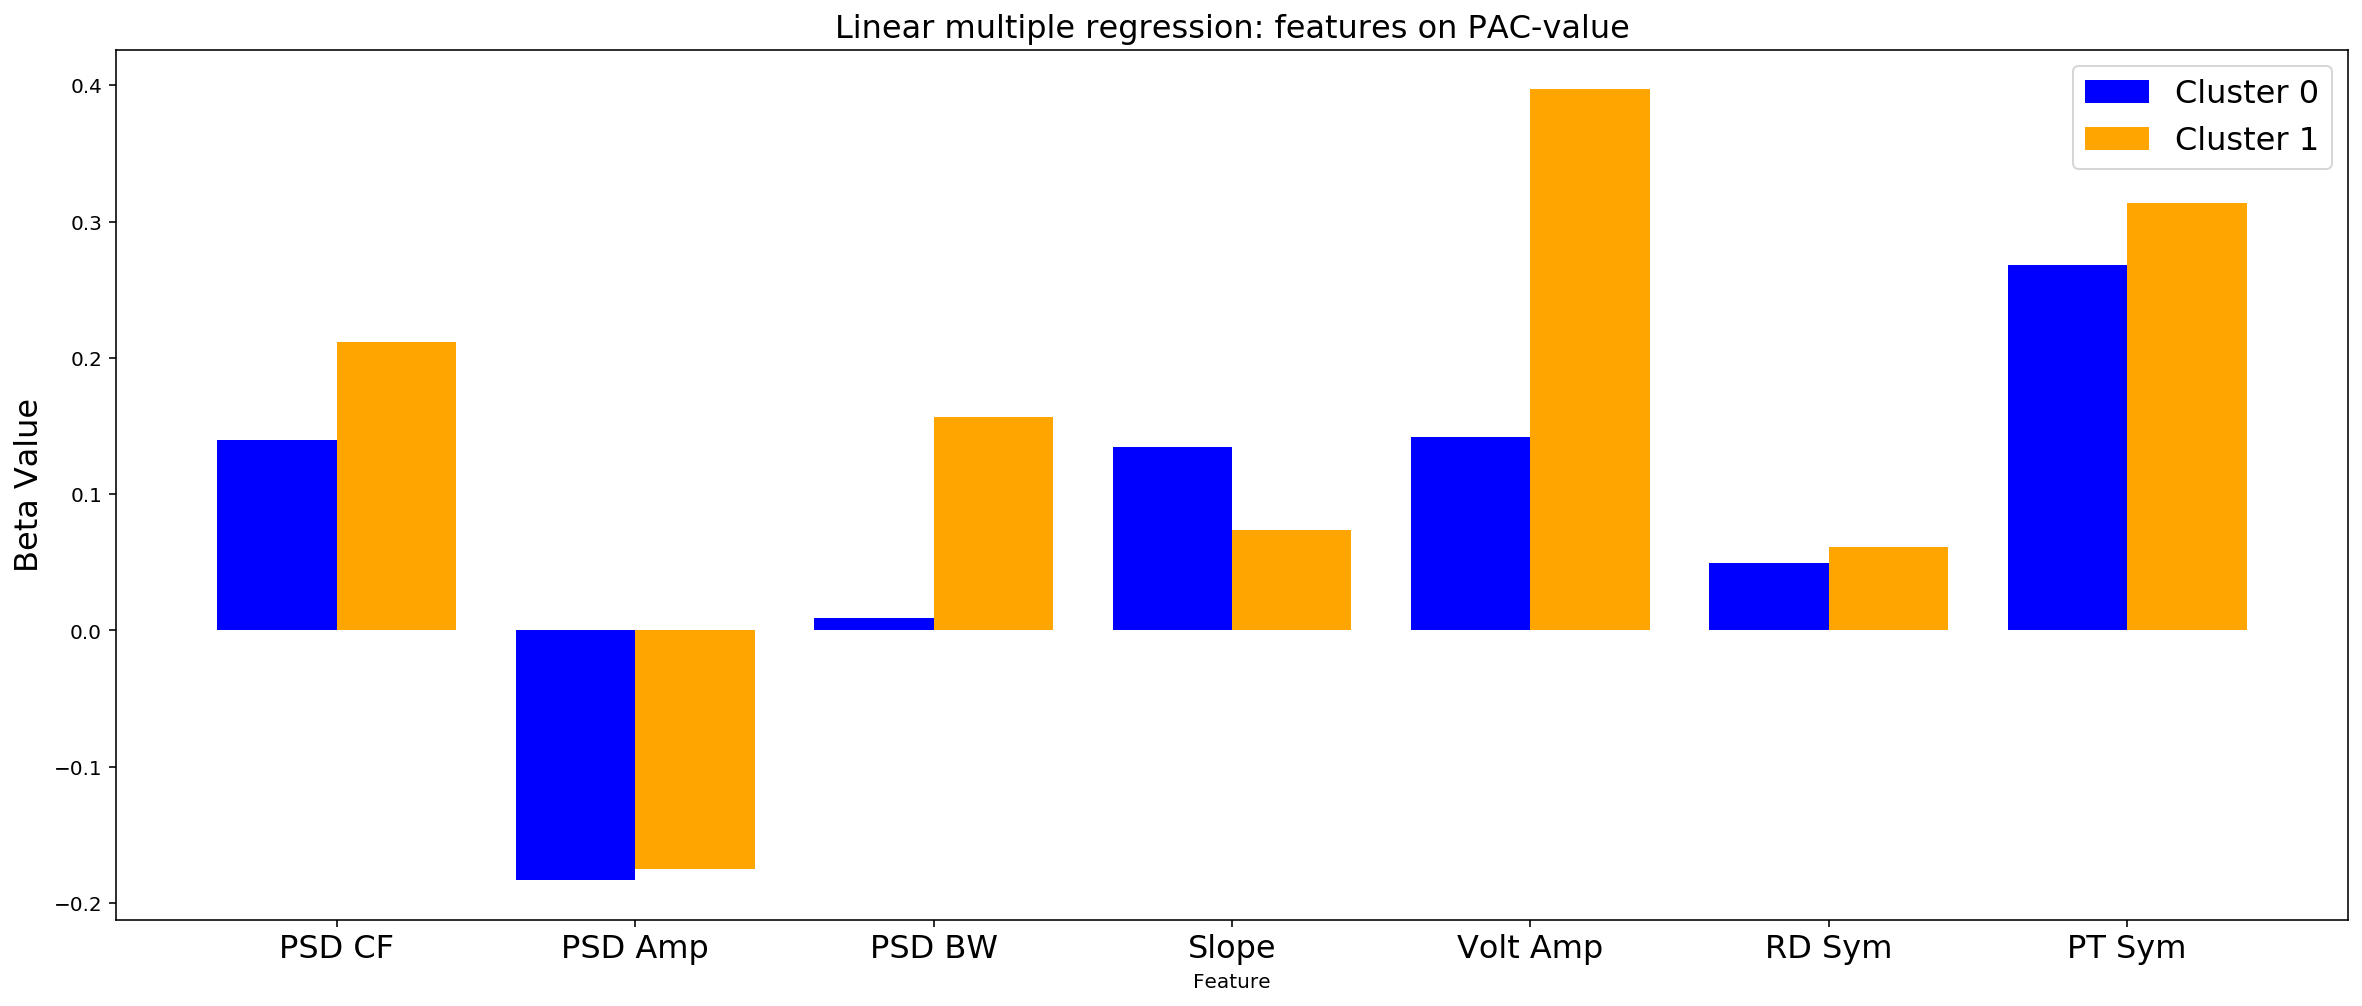

In [20]:
# Create list with feature names for visualization 
feature_list = ['PSD CF', 'PSD Amp', 'PSD BW', 'Slope', \
                'Volt Amp', 'RD Sym', 'PT Sym']

# Plot Beta values for the prediction of the PAC value for cluster 0, cluster 1, and the difference
plt.figure(figsize=(20,8))
index = np.arange(7)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, reg_cluster0.coef_[0], bar_width,
color='blue',
label='Cluster 0')

rects2 = plt.bar(index + bar_width, reg_cluster1.coef_[0], bar_width,
color='orange',
label='Cluster 1')


plt.xlabel('Feature')
plt.ylabel('Beta Value',fontsize=16)
plt.title('Linear multiple regression: features on PAC-value',fontsize=16)
plt.xticks(index + (bar_width/2), feature_list,fontsize=16)
plt.legend(fontsize=16)

# 4. Compare to Non-Significant Channels (that have true oscillation)

So far, we have only looked at the signal that show significant PAC after statistical resampling. But what do the features of signal that DO have a true oscillation (with a CF under 15 Hz, and with an peak Amp between 0.2 and 1.5), but DO NOT have significant PAC after resampling. 

In [21]:
# create X and Y for no pac cluster 
X_cluster13 = np.hstack((
    features_df[features_df['Clusters'] == 13][['CF']].copy(),
    features_df[features_df['Clusters'] == 13][['Amp']].copy(),
    features_df[features_df['Clusters'] == 13][['BW']].copy(),
    features_df[features_df['Clusters'] == 13][['slope']].copy(),
    features_df[features_df['Clusters'] == 13][['volt_amp']].copy(),
    features_df[features_df['Clusters'] == 13][['rdsym']].copy(),
    features_df[features_df['Clusters'] == 13][['ptsym']].copy()))

Y_cluster13 = features_df[features_df['Clusters'] == 13][['pac_values']].copy()

In [22]:
# fit and transform
X_cluster13 = scaler.fit(X_cluster13).transform(X_cluster13)
Y_cluster13 = scaler.fit(Y_cluster13).transform(Y_cluster13)

# regression fit
reg_nopac = linear_model.LinearRegression().fit(X_cluster13, Y_cluster13)


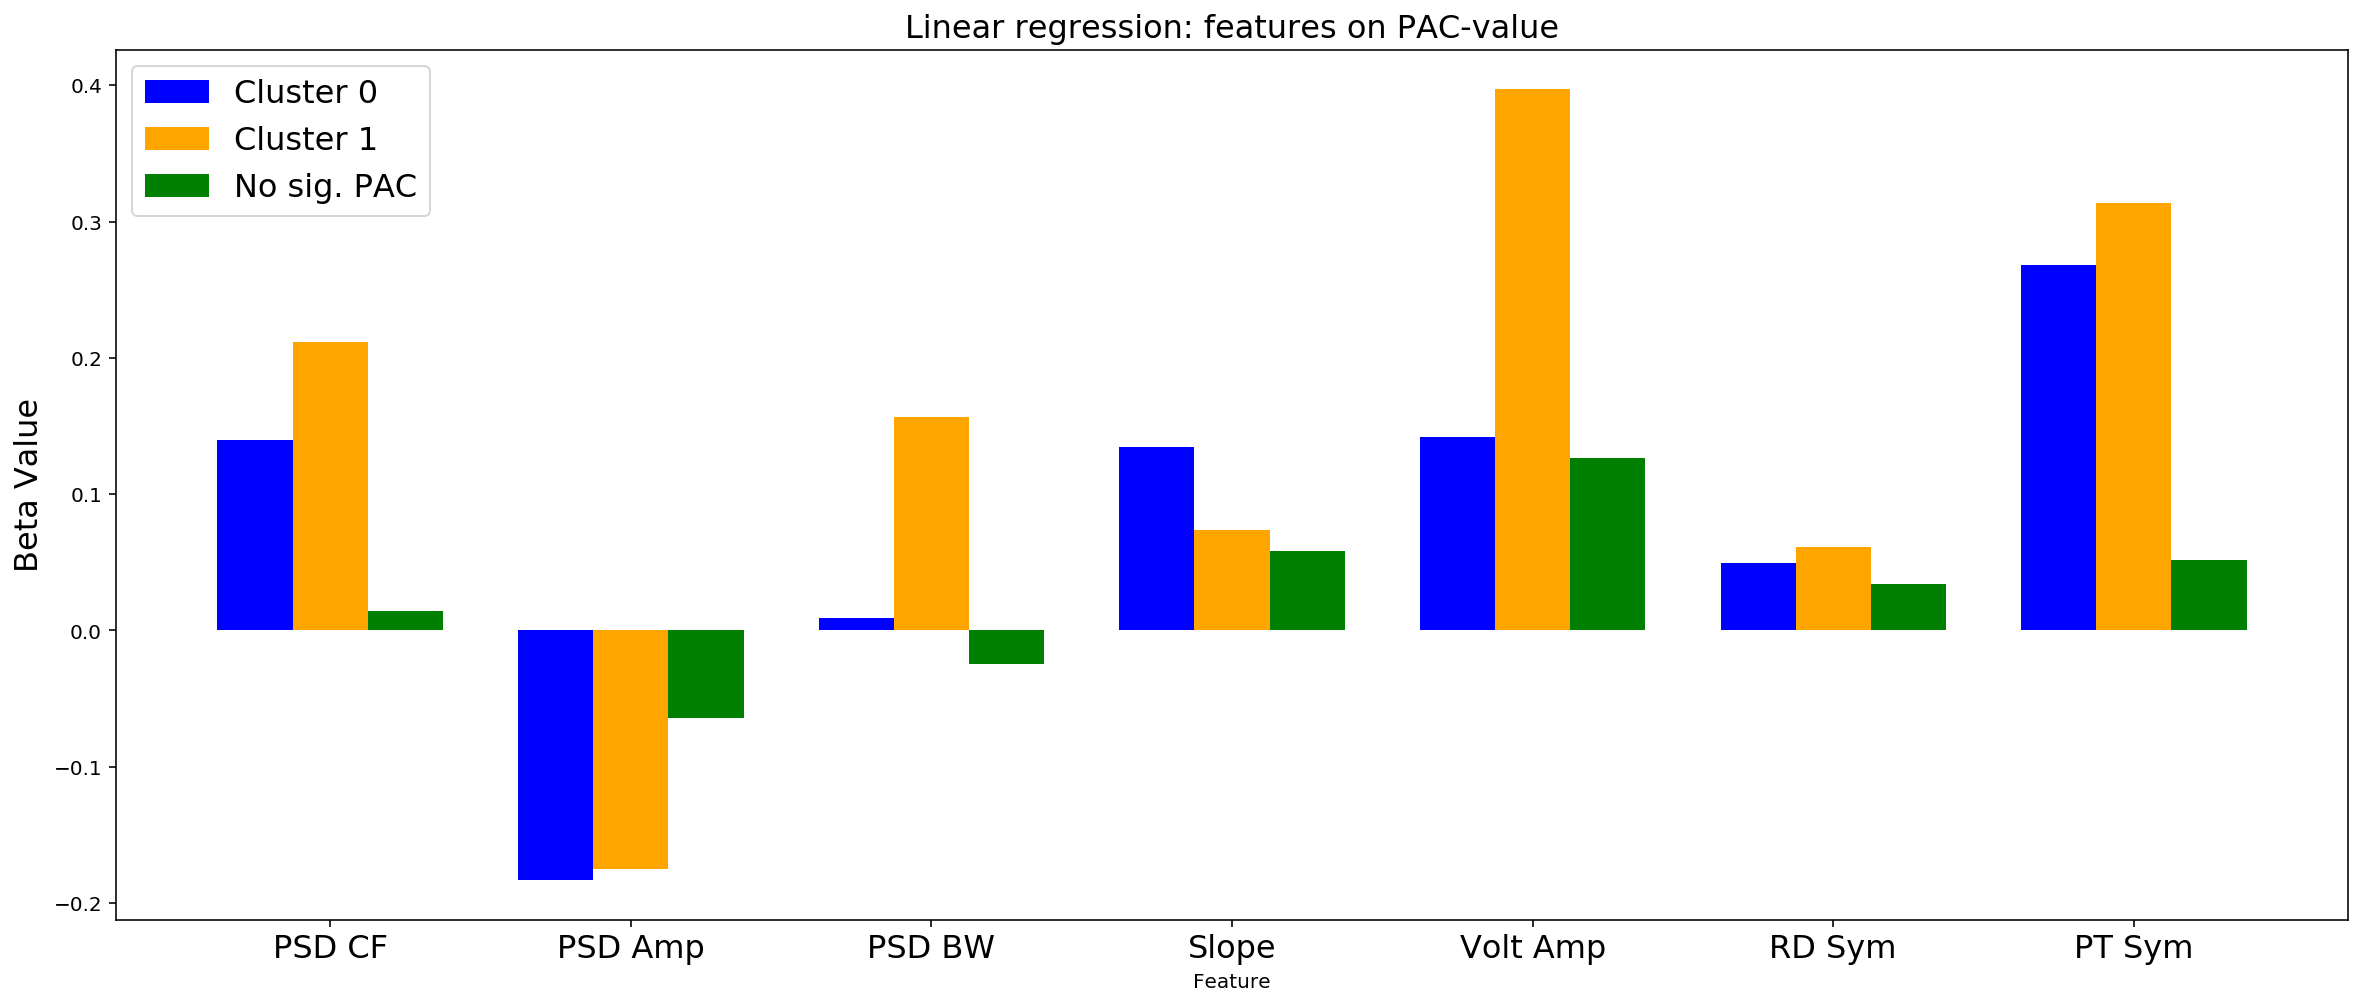

In [23]:
# create plot
plt.figure(figsize=(20,8))
index = np.arange(7)
bar_width = 0.25

rects1 = plt.bar(index, reg_cluster0.coef_[0], bar_width,
color='blue',
label='Cluster 0')

rects2 = plt.bar(index + bar_width, reg_cluster1.coef_[0], bar_width,
color='orange',
label='Cluster 1')

rects3 = plt.bar(index + (bar_width * 2), reg_nopac.coef_[0], bar_width,
color='green',
label='No sig. PAC')

plt.xlabel('Feature')
plt.ylabel('Beta Value',fontsize=16)
plt.title('Linear regression: features on PAC-value',fontsize=16)
plt.xticks(index + bar_width, feature_list,fontsize=16)
plt.legend(fontsize=16)

# 5. Differences in distributions

In [24]:
features_df.columns

Index(['subj', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'offset_long', 'knee_long', 'exp_long', 'pac_presence', 'pac_pvals',
       'pac_rhos', 'resamp_pac_presence', 'resamp_pac_pvals',
       'resamp_pac_zvals', 'volt_amp', 'rdsym', 'ptsym', 'pac_values', 'slope',
       'slope_long', 'Clusters'],
      dtype='object')

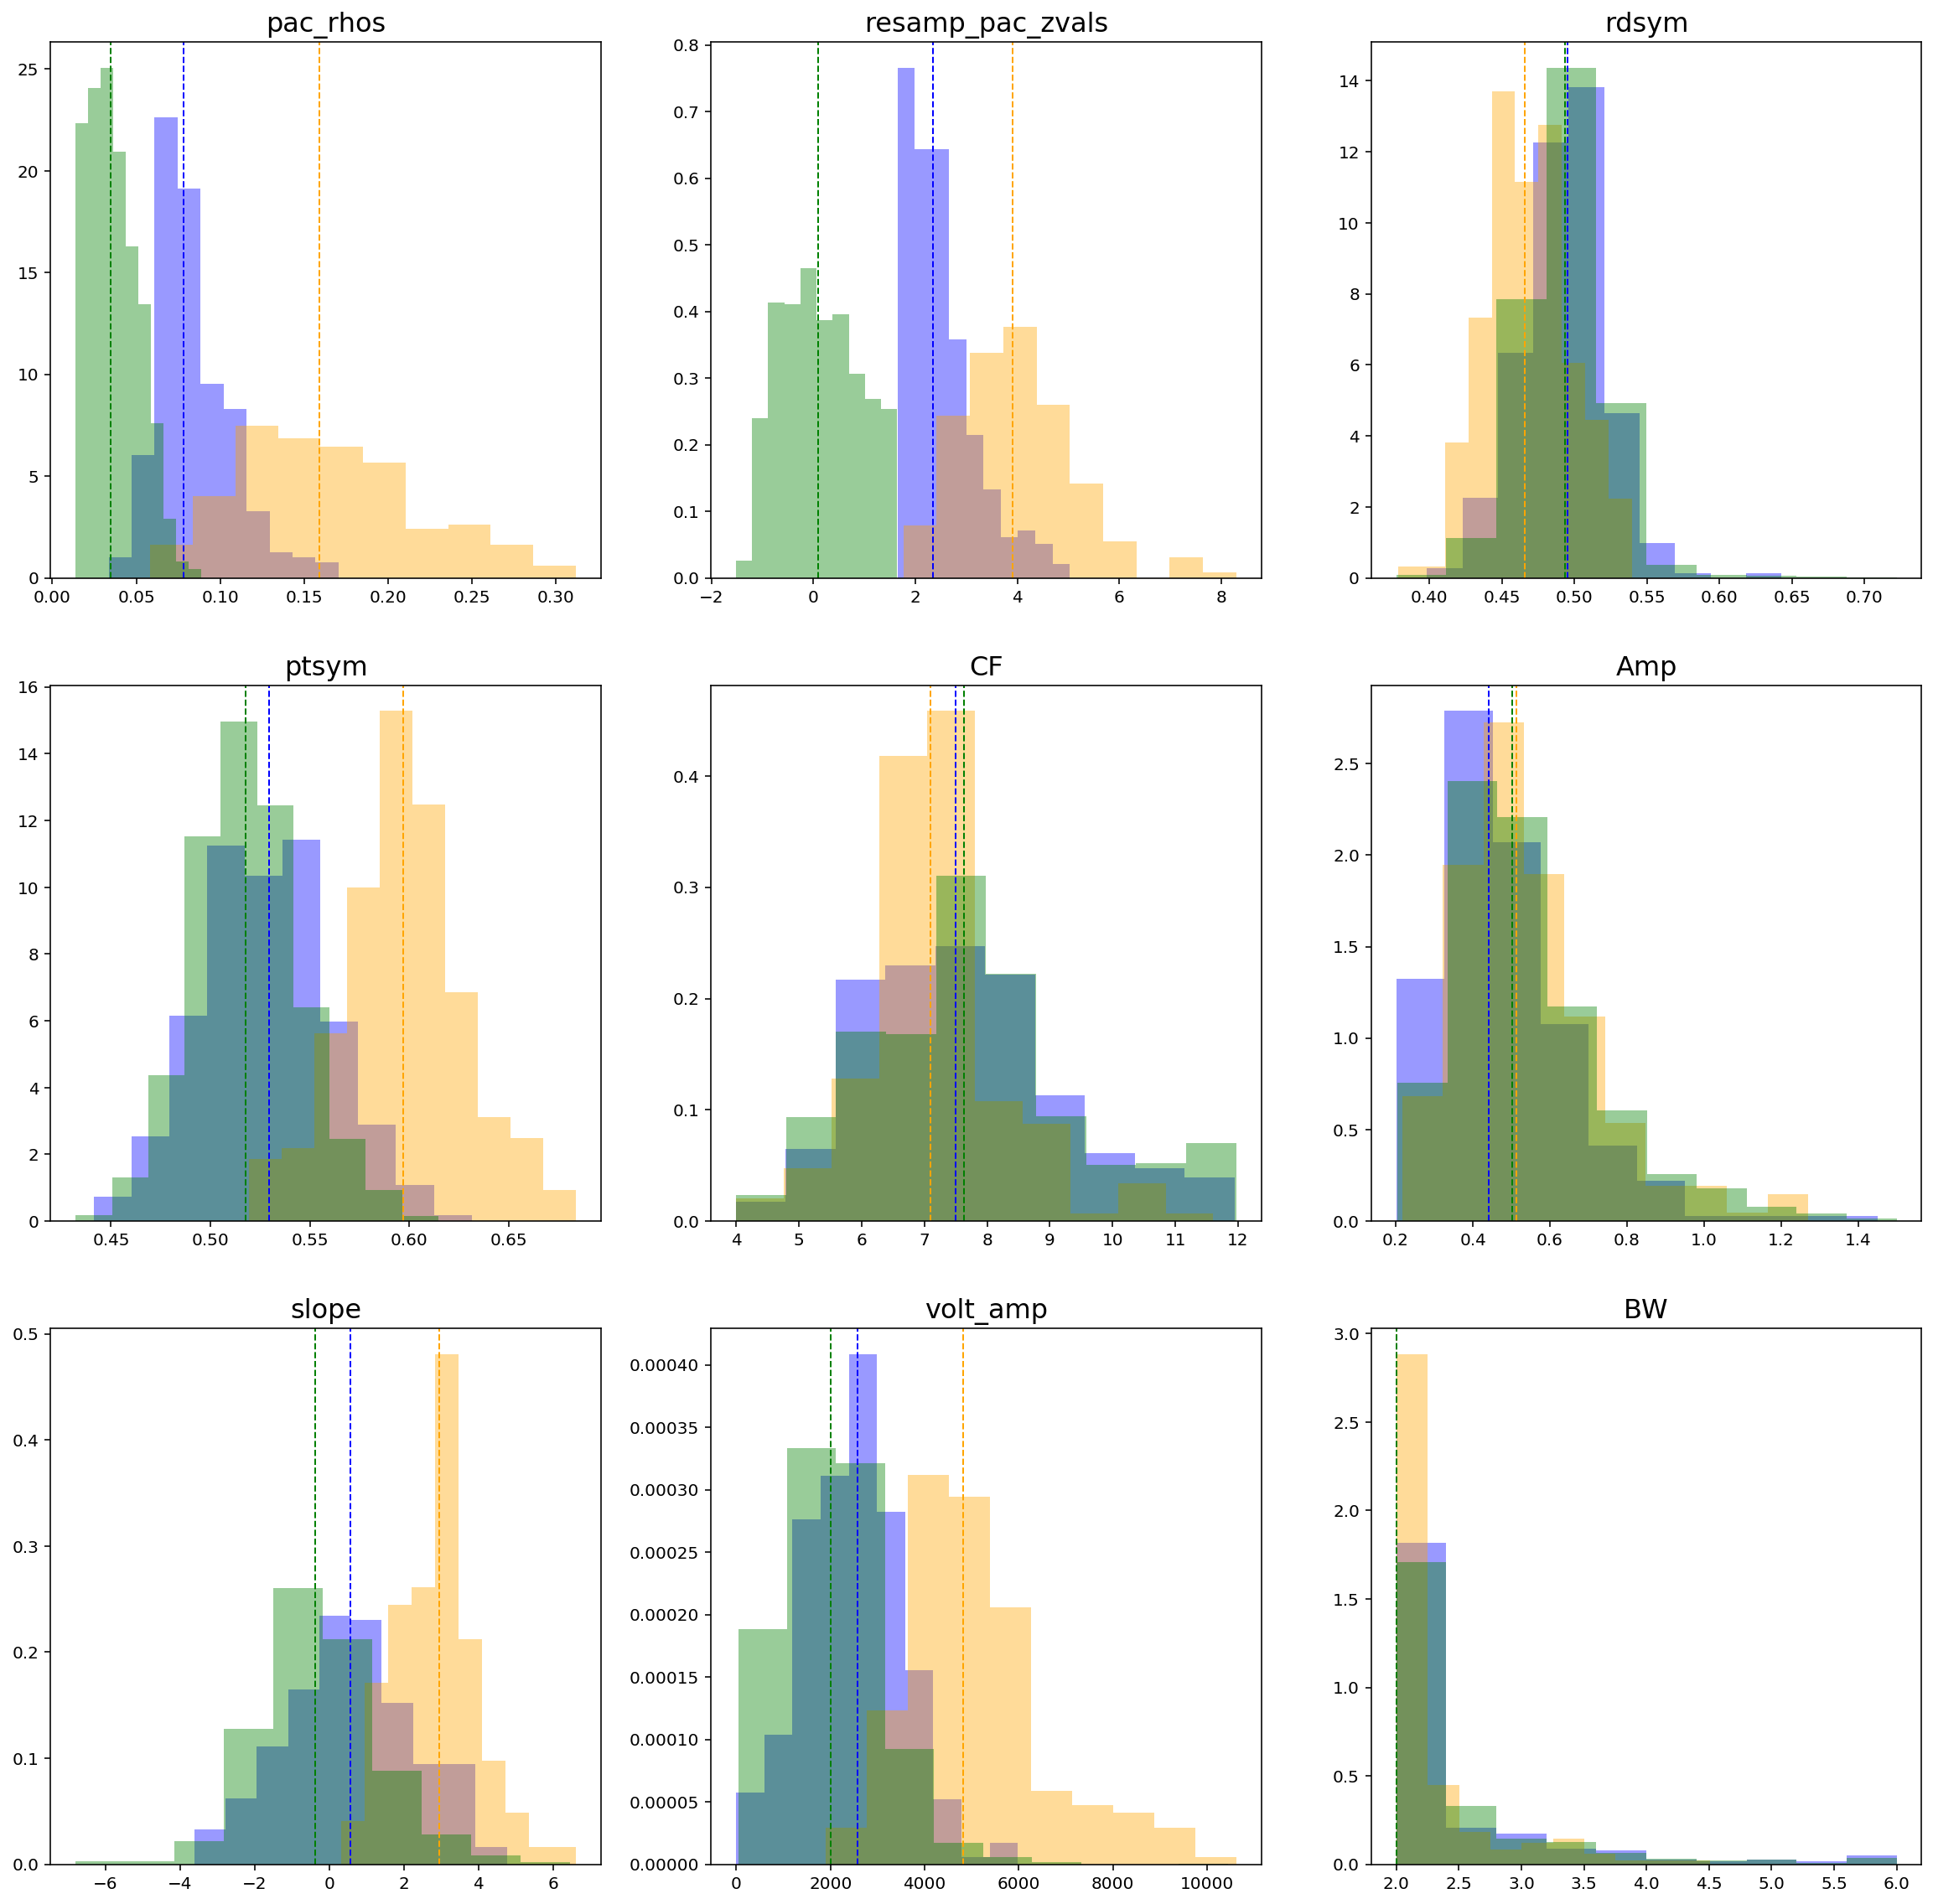

In [25]:
# for statistics
from scipy.stats import f_oneway

# manually set which columns you want to plot
plot_list = [14,17,19,20,3,4,22,18,5] 


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,20))
for ii in range(len(plot_list)): 
        
    jj = plot_list[ii]
    # subplots 3x3
    plt.subplot(3,3,ii+1)
    #xticks([]), yticks([])
    
    plt.hist(features_df[features_df['Clusters']==0][features_df.columns[jj]], color='blue', **kwargs)
    plt.hist(features_df[features_df['Clusters']==1][features_df.columns[jj]], color='orange',**kwargs)
    plt.hist(features_df[features_df['Clusters']==13][features_df.columns[jj]], color='green',**kwargs)

    
    plt.axvline(np.median(features_df[features_df['Clusters']==0][features_df.columns[jj]]), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df[features_df['Clusters']==1][features_df.columns[jj]]), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df[features_df['Clusters']==13][features_df.columns[jj]]), color='green', linestyle='dashed', linewidth=1)
    
    # print statistics
    stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
            features_df[features_df['Clusters']==1][features_df.columns[jj]], 
            features_df[features_df['Clusters']==13][features_df.columns[jj]]) 
    
    # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
    plt.title(features_df.columns[jj], size=16)

<div class="alert alert-success">
Histograms of the distributions of the groups confirm earlier findings. The distrubtion of the No PAC and the true PAC cluster are quiet the same. On some features, the spurious PAC clusters show very different distributions. These include: 
<br><br>
    1. Higher PAC Values
<br>
    2. More Assymetry
<br>
    3. Higher Voltage Amplitude
<br>
    4. Higher Aperiodic Component (backgr_exp)
<br><br>
The PAC value is the outcome value, symmetry measures and higher voltage are known to cause spurious PAC, but the most interesting finding is the difference in the Aperiodic component, which distinguishes between the two PAC clusters. Also, this parameter, interestingly, shows (as only feature) a negative beta coefficient in the spurious PAC cluster, while it is the biggest, positive, bèta coefficient in the true PAC group. 


</div>

# 6. Aperiodic Component / Slope 

### Correlation between slope and slope_long differs a bit per group

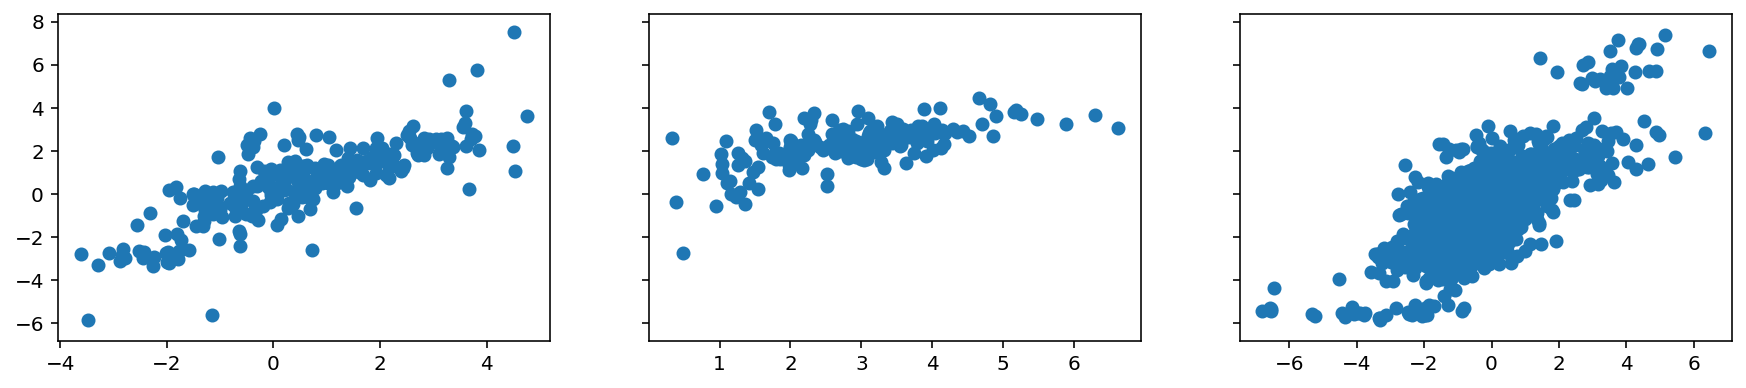

In [26]:
# plot for both the PAC and not PAC dataframes
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

axs[0].scatter(features_df[features_df['Clusters']==0]['slope'], 
               features_df[features_df['Clusters']==0]['slope_long']);

axs[1].scatter(features_df[features_df['Clusters']==1]['slope'], 
               features_df[features_df['Clusters']==1]['slope_long']);

axs[2].scatter(features_df[features_df['Clusters']==13]['slope'], 
               features_df[features_df['Clusters']==13]['slope_long']);


### Difference in distribution

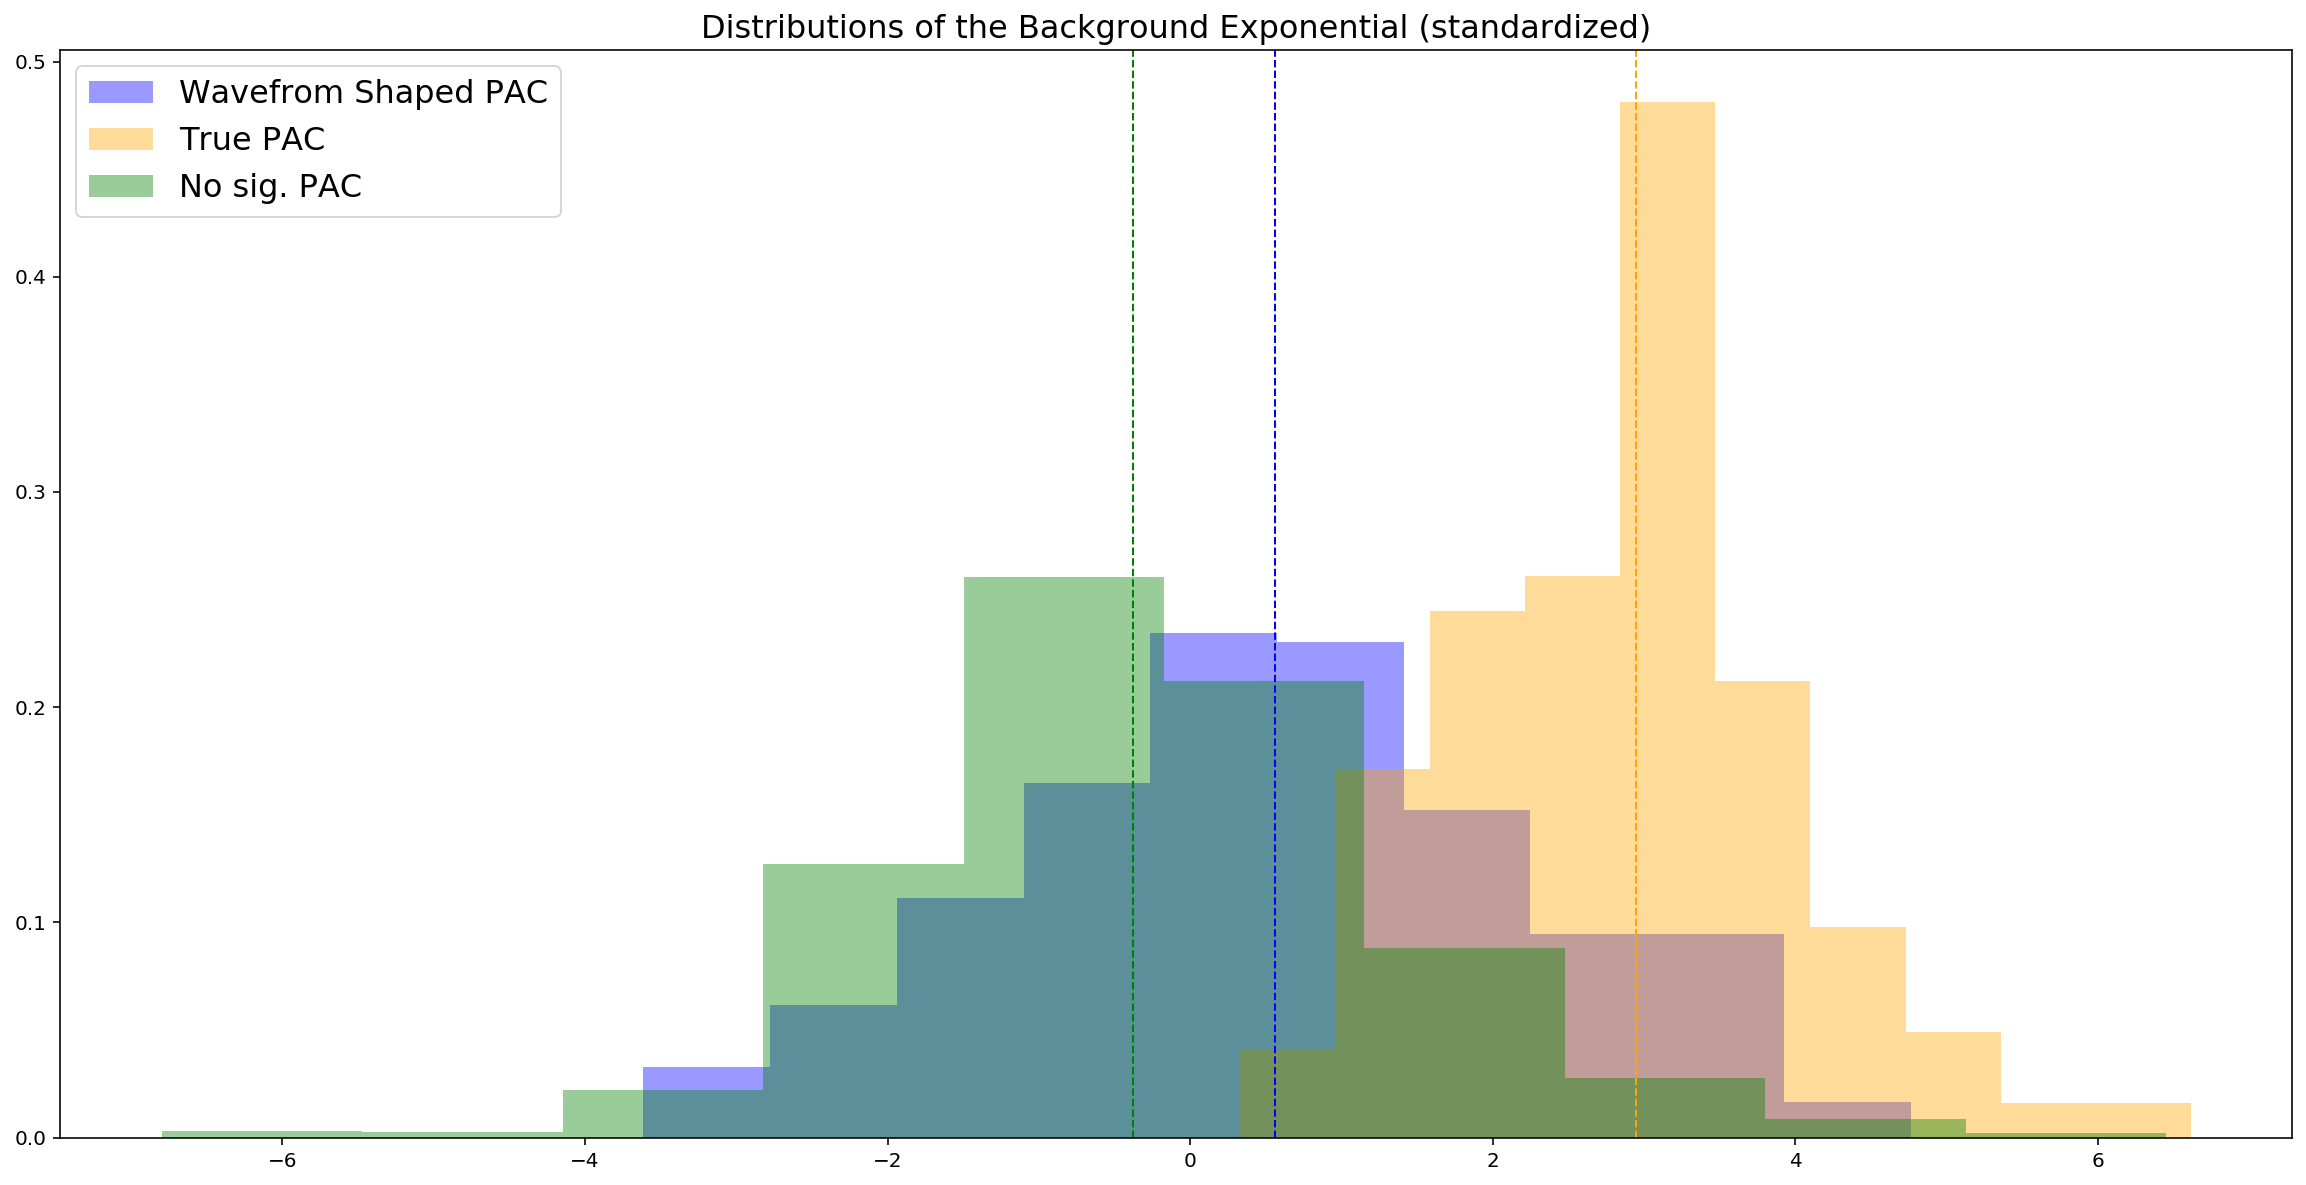

In [27]:
# standardize distributions because 'no PAC' has way more
kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,10))
plt.hist(features_df[features_df['Clusters']==0]['slope'], color='blue', label='Wavefrom Shaped PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==1]['slope'], color='orange', label='True PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==13]['slope'], color='green', label='No sig. PAC', **kwargs);

plt.title('Distributions of the Background Exponential (standardized)', fontsize=16)
plt.legend(fontsize=16)

plt.axvline(np.median(features_df[features_df['Clusters']==0]['slope']), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==1]['slope']), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==13]['slope']), color='green', linestyle='dashed', linewidth=1)


### Predicting PAC values with Aperiodic Component

In [28]:
# transform to SKlearn for linear regressions

# reshape pac_values
pac_values_clus0 = features_df[features_df['Clusters']==0]['pac_values'].values.reshape(-1,1)
pac_values_clus1 = features_df[features_df['Clusters']==1]['pac_values'].values.reshape(-1,1)
pac_values_nopac = features_df[features_df['Clusters']==13]['pac_values'].values.reshape(-1,1)

# reshape backgr_exp
slope_clus0 = features_df[features_df['Clusters']==0]['slope'].values.reshape(-1,1)
slope_clus1 = features_df[features_df['Clusters']==1]['slope'].values.reshape(-1,1)
slope_nopac = features_df[features_df['Clusters']==13]['slope'].values.reshape(-1,1)

# Reshape Rho values
pac_rhos_clus0 = features_df[features_df['Clusters']==0]['pac_rhos'].values.reshape(-1,1)
pac_rhos_clus1 = features_df[features_df['Clusters']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_nopac = features_df[features_df['Clusters']==13]['pac_rhos'].values.reshape(-1,1)

# reshape resamp_zvals
resamp_zvals_clus0 = features_df[features_df['Clusters']==0]['resamp_pac_zvals'].values.reshape(-1,1)
resamp_zvals_clus1 = features_df[features_df['Clusters']==1]['resamp_pac_zvals'].values.reshape(-1,1)
resamp_zvals_nopac = features_df[features_df['Clusters']==13]['resamp_pac_zvals'].values.reshape(-1,1)

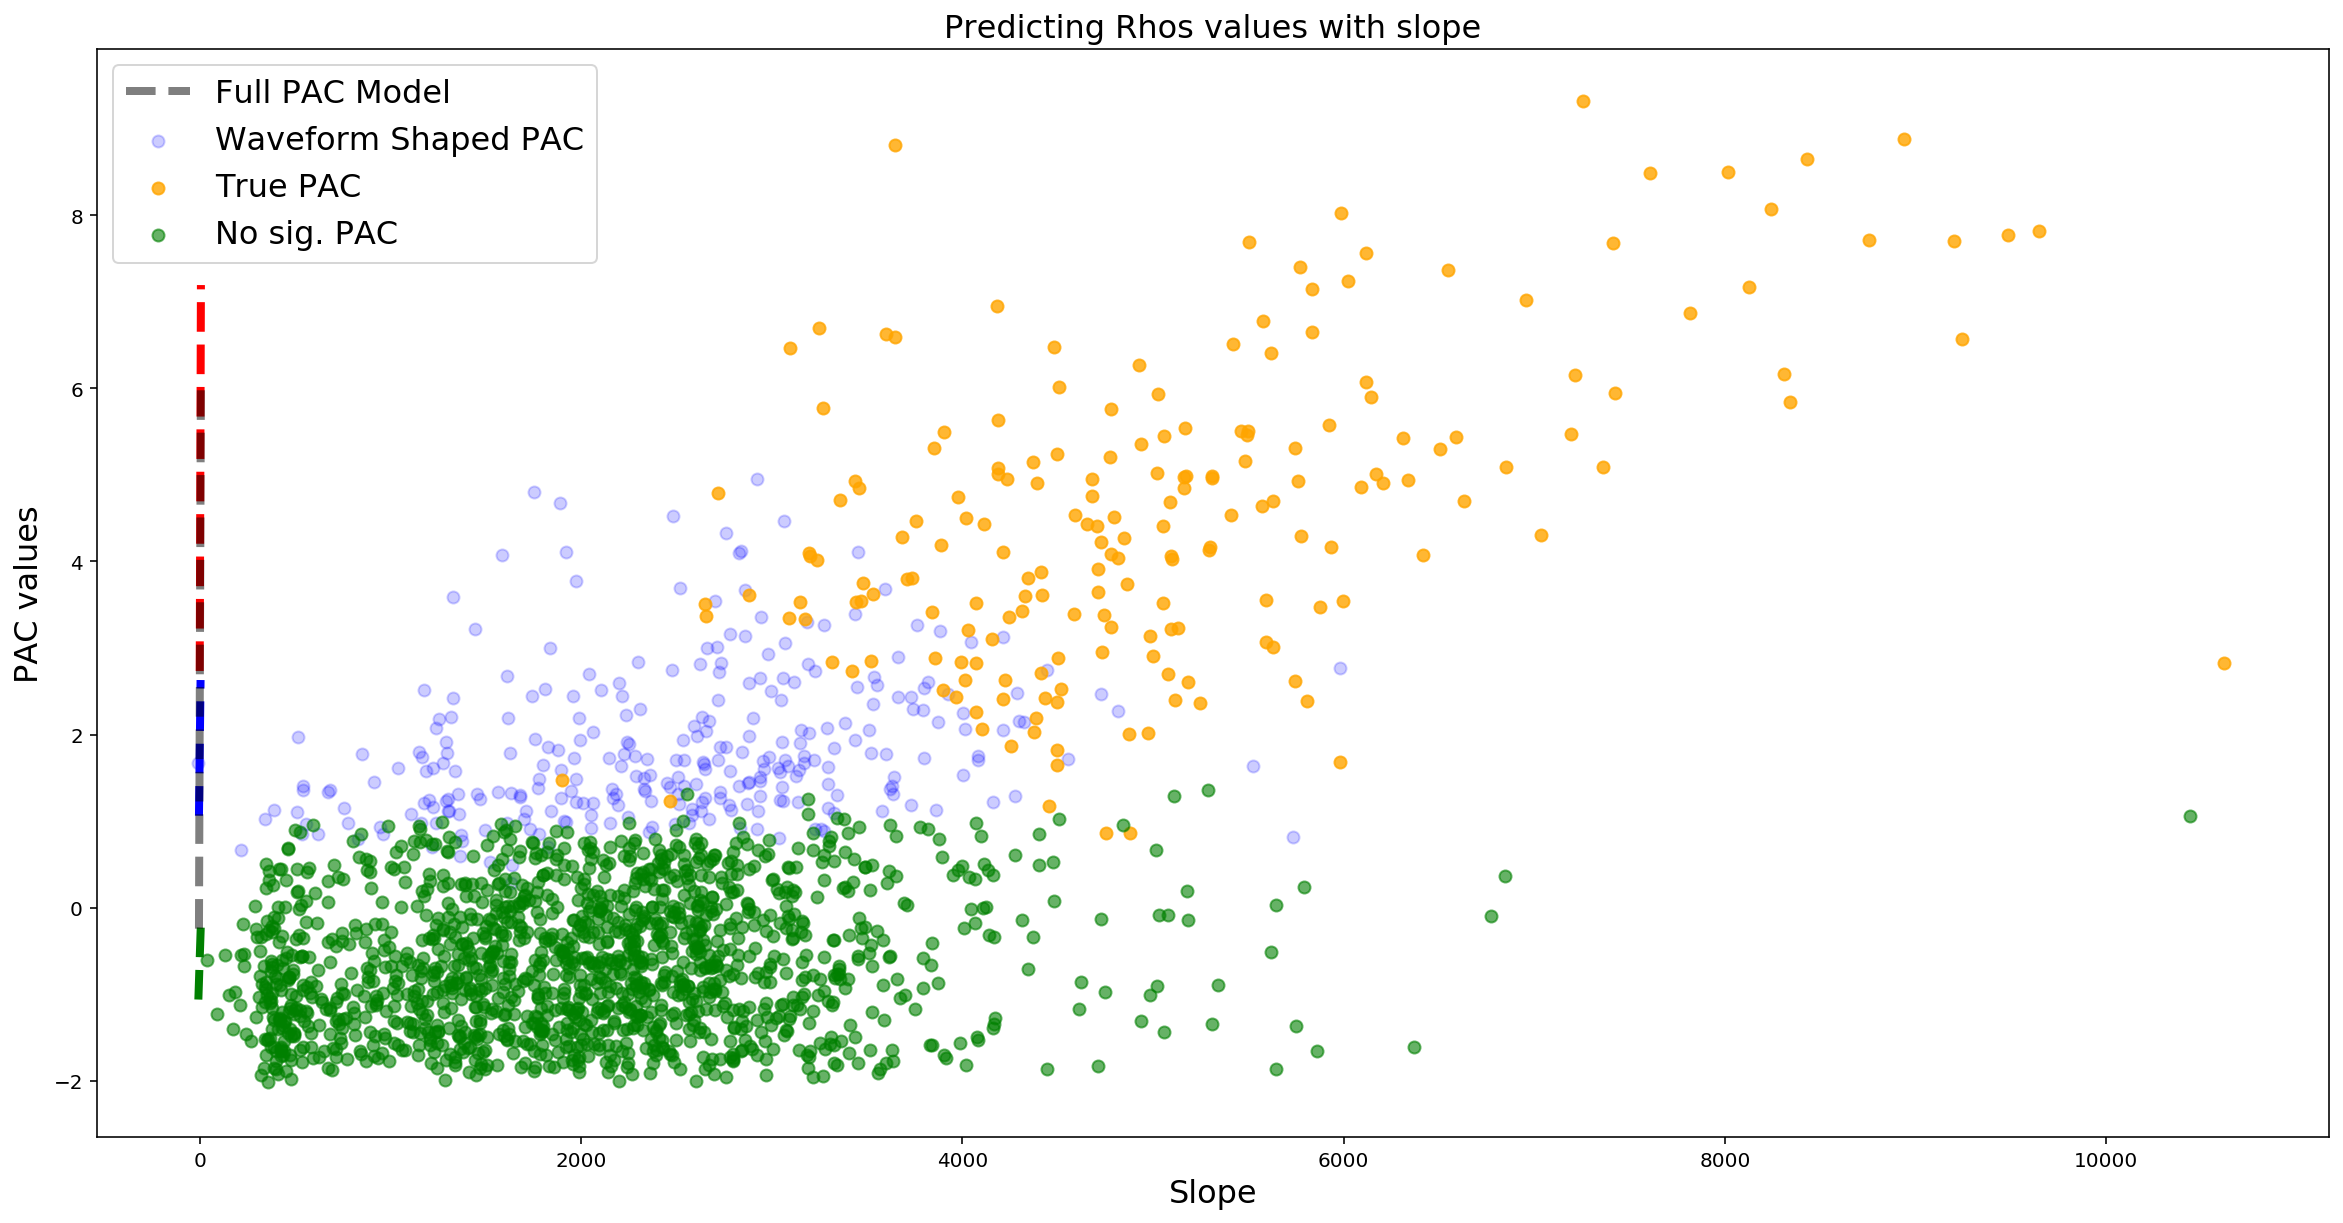

In [29]:
plt.figure(figsize=(20,10))

# Cluster 0: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==0]['volt_amp'],
            features_df[features_df['Clusters']==0]['pac_values'],
           color='blue', alpha =.2, label='Waveform Shaped PAC')

reg1 = linear_model.LinearRegression()
reg1.fit(slope_clus0, pac_values_clus0)
xs = np.arange(min(slope_clus0), max(slope_clus0),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--b', linewidth=4, alpha=1)

# Cluster 1: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==1]['volt_amp'],
            features_df[features_df['Clusters']==1]['pac_values'],
           color='orange', alpha =.8, label='True PAC')

reg2 = linear_model.LinearRegression()
reg2.fit(slope_clus1, pac_values_clus1)
xs = np.arange(min(slope_clus1), max(slope_clus1),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--r', linewidth=4, alpha=1)

# No PAC: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==13]['volt_amp'],
            features_df[features_df['Clusters']==13]['pac_values'],
           color='green', alpha =.6, label='No sig. PAC')

reg3 = linear_model.LinearRegression()
reg3.fit(slope_nopac, pac_values_nopac)
xs = np.arange(min(slope_nopac), max(slope_nopac),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--g', linewidth=4, alpha=1)


# Regression model on all combined
# concatenate the three groups and reshape
pac_values_comb = np.reshape(np.concatenate((pac_values_clus0, pac_values_clus1), axis=None), [-1, 1])
slope_comb = np.reshape(np.concatenate((slope_clus0, slope_clus1), axis=None), [-1, 1])

reg4= linear_model.LinearRegression()
reg4.fit(slope_comb, pac_values_comb)
xs = np.arange(min(slope_comb), max(slope_comb),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--k', linewidth=4, label='Full PAC Model', alpha=.5)


plt.title('Predicting Rhos values with slope', fontsize=16)
plt.xlabel('Slope', fontsize=16)
plt.ylabel('PAC values', fontsize=16)
plt.legend(fontsize=16)
plt.show()

# 7. Regression on other features

In [30]:
features_df.columns

Index(['subj', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'offset_long', 'knee_long', 'exp_long', 'pac_presence', 'pac_pvals',
       'pac_rhos', 'resamp_pac_presence', 'resamp_pac_pvals',
       'resamp_pac_zvals', 'volt_amp', 'rdsym', 'ptsym', 'pac_values', 'slope',
       'slope_long', 'Clusters'],
      dtype='object')

In [31]:
# put in the feature for reshape
feature_clus0 = features_df[features_df['Clusters']==0]['ptsym'].values.reshape(-1,1)
feature_clus1 = features_df[features_df['Clusters']==1]['ptsym'].values.reshape(-1,1)
feature_nopac = features_df[features_df['Clusters']==13]['ptsym'].values.reshape(-1,1)


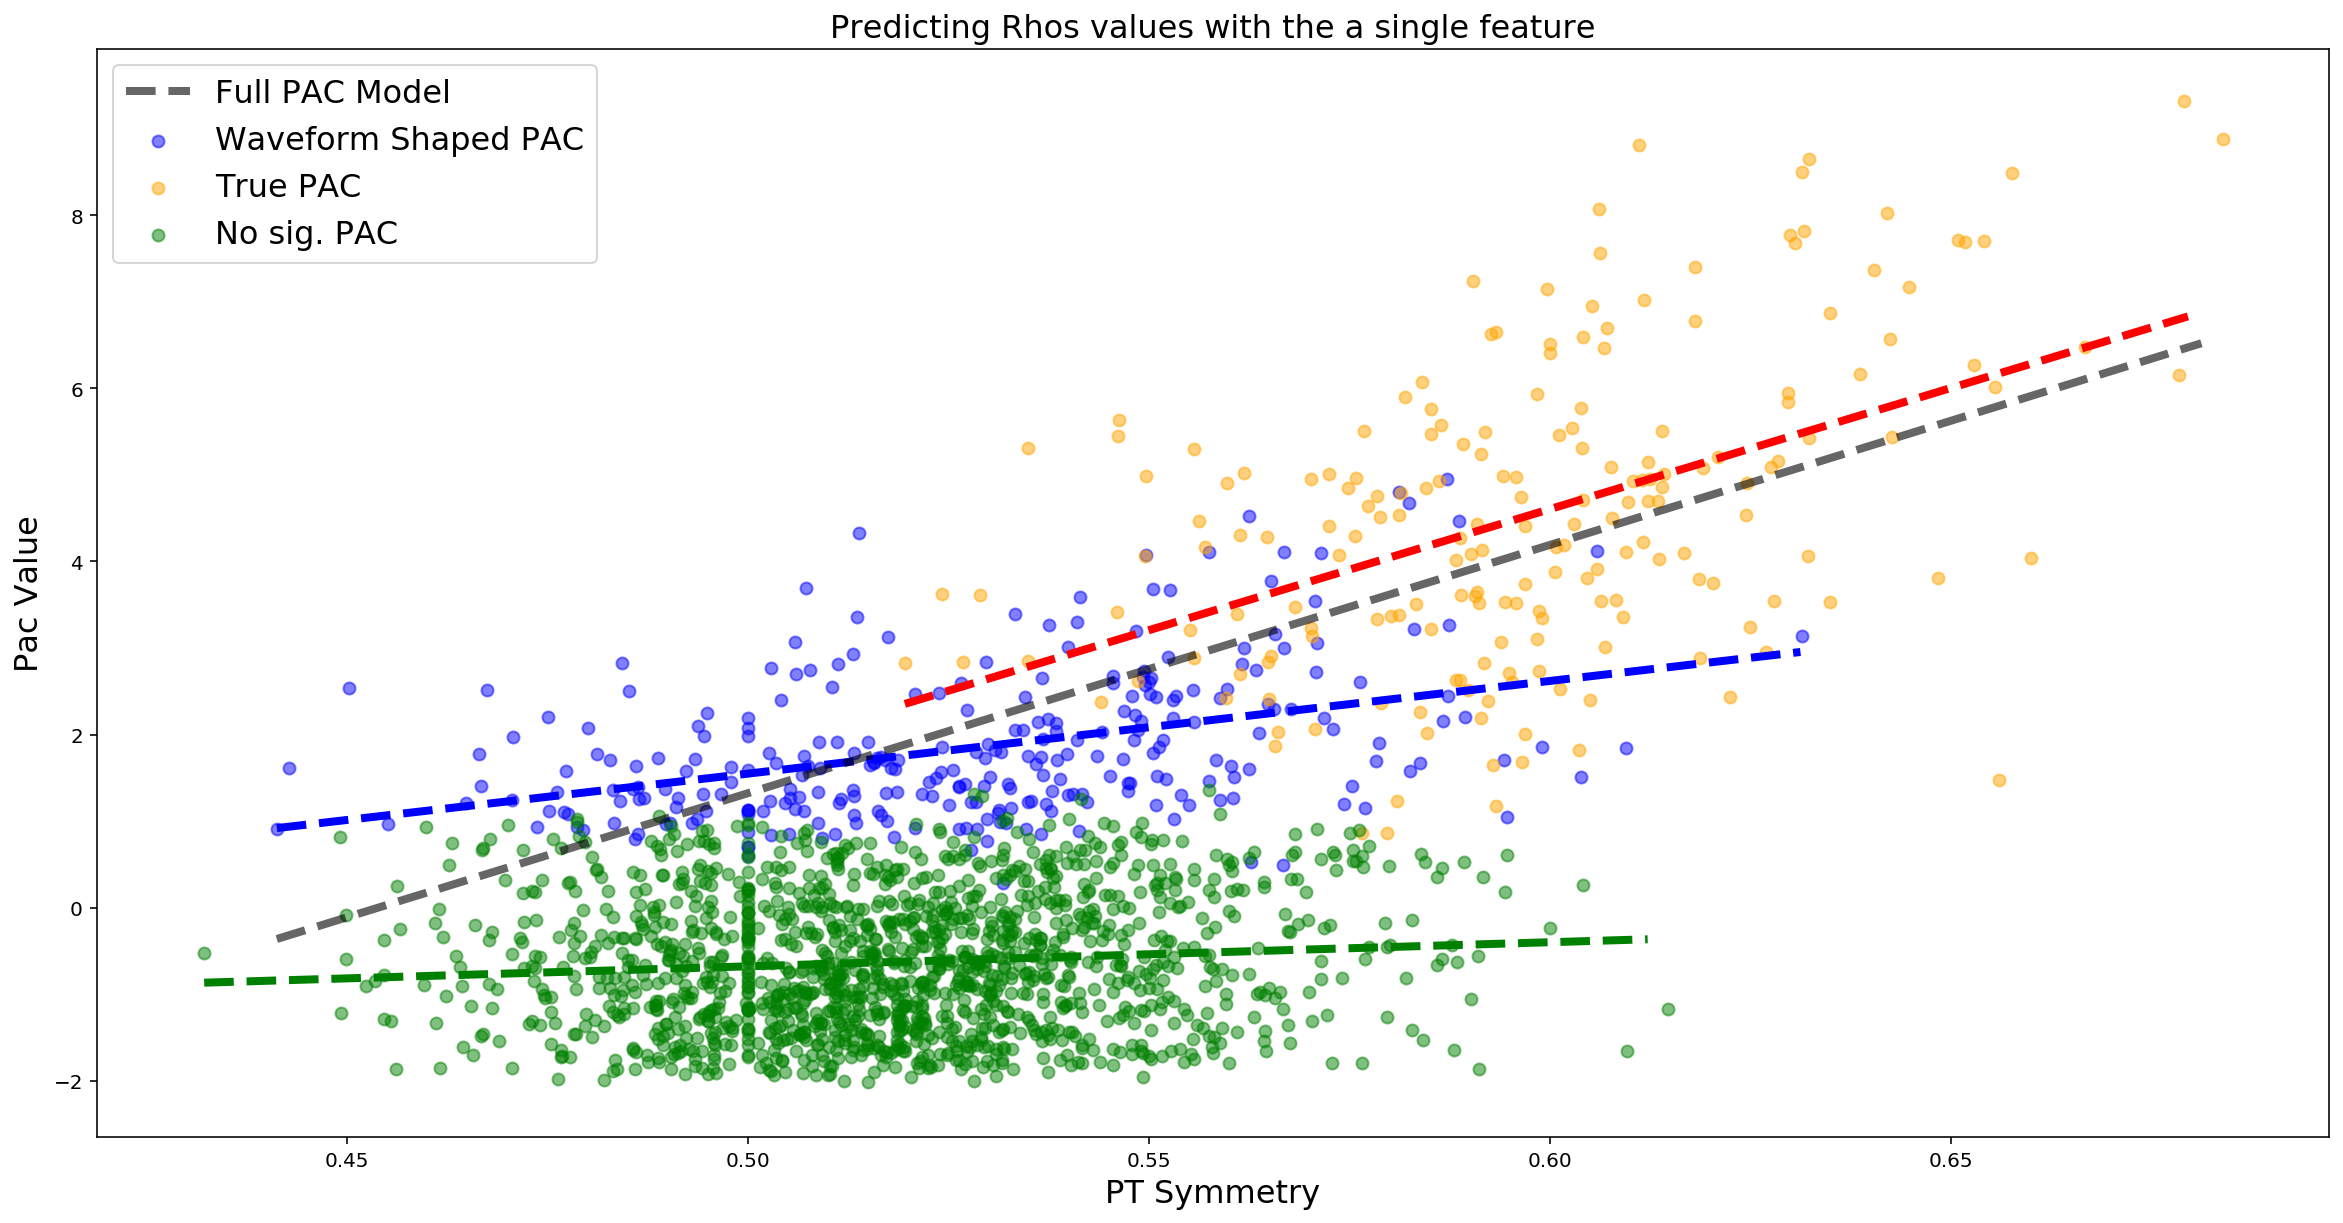

In [33]:
plt.figure(figsize=(20,10))

# Cluster 0: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==0]['ptsym'],
            features_df[features_df['Clusters']==0]['pac_values'],
           color='blue', alpha =.5, label='Waveform Shaped PAC')

# Cluster 1: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==1]['ptsym'],
            features_df[features_df['Clusters']==1]['pac_values'],
           color='orange', alpha =.5, label='True PAC')

# No PAC: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==13]['ptsym'],
            features_df[features_df['Clusters']==13]['pac_values'],
           color='green', alpha =.5, label='No sig. PAC')

# regression cluster 0
reg1 = linear_model.LinearRegression()
reg1.fit(feature_clus0, pac_values_clus0)
xs = np.arange(min(feature_clus0), max(feature_clus0),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--b', linewidth=4, alpha=1)

# regression cluster 1
reg2 = linear_model.LinearRegression()
reg2.fit(feature_clus1, pac_values_clus1)
xs = np.arange(min(feature_clus1), max(feature_clus1),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--r', linewidth=4, alpha=1)


# regression no pac
reg3 = linear_model.LinearRegression()
reg3.fit(feature_nopac, pac_values_nopac)
xs = np.arange(min(feature_nopac), max(feature_nopac),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--g', linewidth=4, alpha=1)

# Regression model on all combined
# concatenate the three groups and reshape
pac_rhos_comb = np.reshape(np.concatenate((pac_values_clus0, pac_values_clus1), axis=None), [-1, 1])
feature_comb = np.reshape(np.concatenate((feature_clus0, feature_clus1), axis=None), [-1, 1])

# regression combo
reg4= linear_model.LinearRegression()
reg4.fit(feature_comb, pac_rhos_comb)
xs = np.arange(min(feature_comb), max(feature_comb),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--k', linewidth=4, label='Full PAC Model', alpha=.6)


plt.title('Predicting Rhos values with the a single feature', fontsize=16)
plt.xlabel('PT Symmetry', fontsize=16)
plt.ylabel('Pac Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

# 8. Regressions including no sig. PAC before resampling in black

In [34]:
# put in the feature for reshape
feature_clus0 = features_df[features_df['Clusters']==0]['slope'].values.reshape(-1,1)
feature_clus1 = features_df[features_df['Clusters']==1]['slope'].values.reshape(-1,1)
feature_nopac = features_df[features_df['Clusters']==13]['slope'].values.reshape(-1,1)
feature_initialpac = features_df[features_df['Clusters']==12]['slope'].values.reshape(-1,1)

# reshape pac_values
pac_values_clus0 = features_df[features_df['Clusters']==0]['pac_values'].values.reshape(-1,1)
pac_values_clus1 = features_df[features_df['Clusters']==1]['pac_values'].values.reshape(-1,1)
pac_values_nopac = features_df[features_df['Clusters']==13]['pac_values'].values.reshape(-1,1)
pac_values_initialpac = features_df[features_df['Clusters']==12]['pac_values'].values.reshape(-1,1)

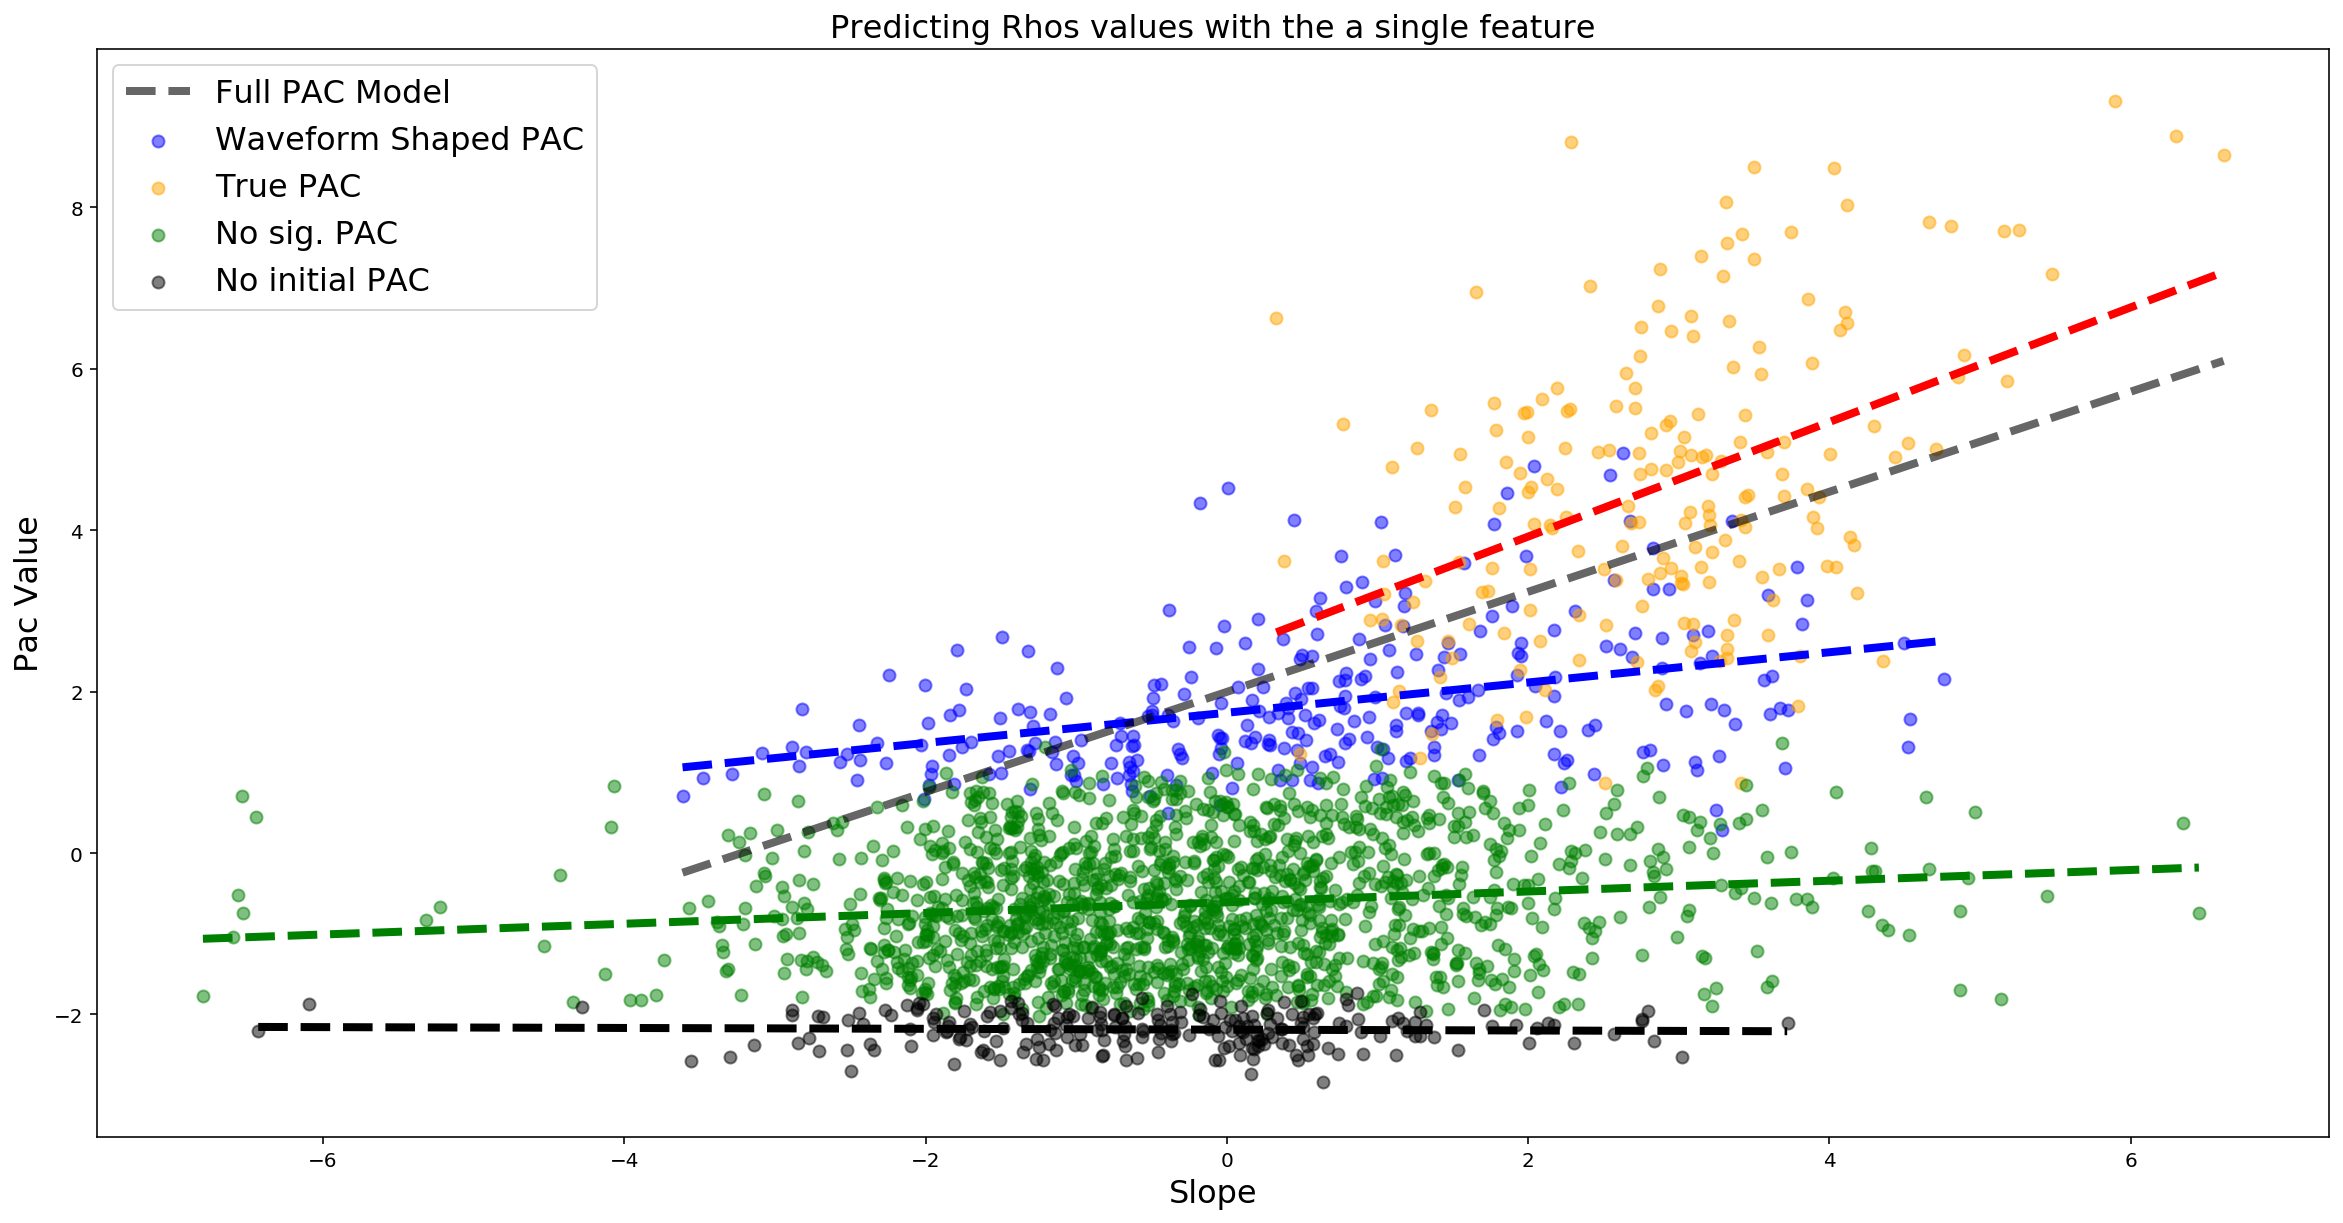

In [37]:
plt.figure(figsize=(20,10))

# Cluster 0: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==0]['slope'],
            features_df[features_df['Clusters']==0]['pac_values'],
           color='blue', alpha =.5, label='Waveform Shaped PAC')

# Cluster 1: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==1]['slope'],
            features_df[features_df['Clusters']==1]['pac_values'],
           color='orange', alpha =.5, label='True PAC')

# No PAC: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==13]['slope'],
            features_df[features_df['Clusters']==13]['pac_values'],
           color='green', alpha =.5, label='No sig. PAC')

# No initial PAC: scatter + linear regression
plt.scatter(features_df[features_df['Clusters']==12]['slope'],
            features_df[features_df['Clusters']==12]['pac_values'],
           color='black', alpha =.5, label='No initial PAC')


# regression cluster 0
reg1 = linear_model.LinearRegression()
reg1.fit(feature_clus0, pac_values_clus0)
xs = np.arange(min(feature_clus0), max(feature_clus0),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--b', linewidth=4, alpha=1)

# regression cluster 1
reg2 = linear_model.LinearRegression()
reg2.fit(feature_clus1, pac_values_clus1)
xs = np.arange(min(feature_clus1), max(feature_clus1),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--r', linewidth=4, alpha=1)

# regression no pac
reg3 = linear_model.LinearRegression()
reg3.fit(feature_nopac, pac_values_nopac)
xs = np.arange(min(feature_nopac), max(feature_nopac),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--g', linewidth=4, alpha=1)

# regression no initial pac
reg5 = linear_model.LinearRegression()
reg5.fit(feature_initialpac, pac_values_initialpac)
xs = np.arange(min(feature_initialpac), max(feature_initialpac),0.01)
ys = reg5.intercept_[0] + reg5.coef_[0][0] * xs
plt.plot(xs, ys, '--k', linewidth=4, alpha=1)


# Regression model on all combined
# concatenate the three groups and reshape
pac_rhos_comb = np.reshape(np.concatenate((pac_values_clus0, pac_values_clus1), axis=None), [-1, 1])
feature_comb = np.reshape(np.concatenate((feature_clus0, feature_clus1), axis=None), [-1, 1])

# regression combo
reg4= linear_model.LinearRegression()
reg4.fit(feature_comb, pac_rhos_comb)
xs = np.arange(min(feature_comb), max(feature_comb),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--k', linewidth=4, label='Full PAC Model', alpha=.6)


plt.title('Predicting Rhos values with the a single feature', fontsize=16)
plt.xlabel('Slope', fontsize=16)
plt.ylabel('Pac Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

# 9. Distributions of all clusters

C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


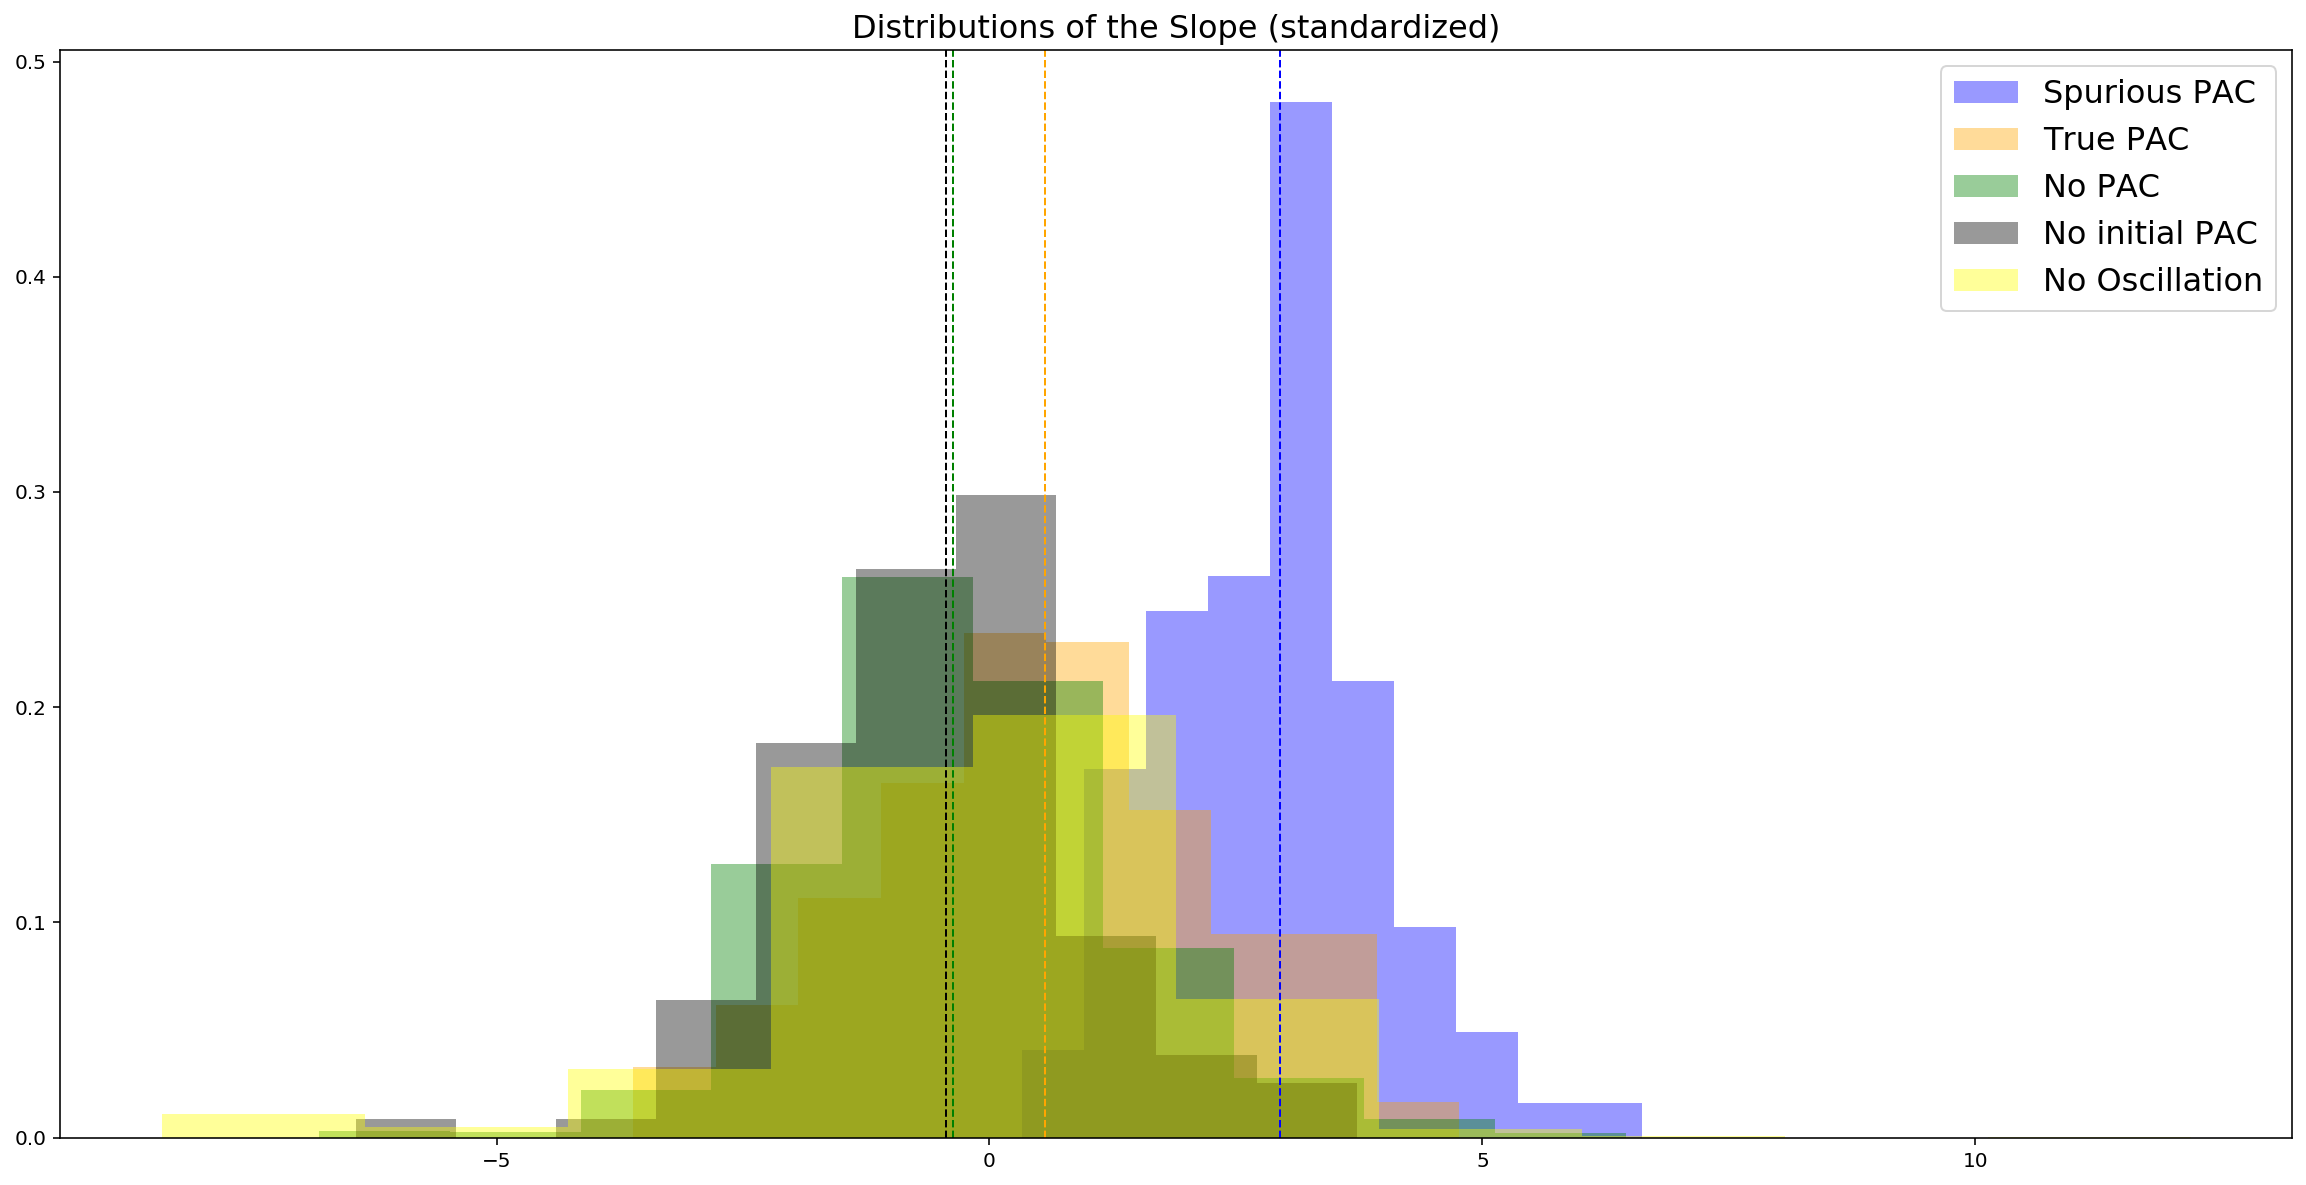

In [50]:
# standardize distributions because 'no PAC' has way more
kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,10))
plt.hist(features_df[features_df['Clusters']==0]['slope'], color='blue', label='Spurious PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==1]['slope'], color='orange', label='True PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==13]['slope'], color='green', label='No PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==12]['slope'], color='black', label='No initial PAC', **kwargs);
plt.hist(features_df[features_df['Clusters']==11]['slope'], color='yellow', label='No Oscillation', **kwargs);

plt.title('Distributions of the Slope (standardized)', fontsize=16)
plt.legend(fontsize=16)

plt.axvline(np.median(features_df[features_df['Clusters']==0]['slope']), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==1]['slope']), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==13]['slope']), color='green', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==12]['slope']), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.median(features_df[features_df['Clusters']==11]['slope']), color='yellow', linestyle='dashed', linewidth=1)


In [51]:
len(features_df[(features_df['CF'] < 12) & (features_df['CF'] > 4)])

2180

In [52]:
features_df[4020:5720][(features_df['CF'] < 12) & (features_df['CF'] > 4)]


C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,subj,ch,ep,CF,Amp,BW,offset,knee,exp,offset_long,knee_long,exp_long,pac_presence,pac_pvals,pac_rhos,resamp_pac_presence,resamp_pac_pvals,resamp_pac_zvals,volt_amp,rdsym,ptsym,pac_values,slope,slope_long,Clusters
4022,14,20,2,9.387379,0.457939,2.000000,7.492665,-31.139121,2.968543,6.873924,-26.364358,2.552241,1,1.826317e-13,0.052050,0,0.106304,1.246424,2816.918986,0.504202,0.513274,0.389935,0.155705,-0.035823,13.0
4025,14,21,0,6.896867,0.392718,2.000000,7.777712,-49.251348,3.282625,6.699861,-26.738271,2.502076,1,0.000000e+00,0.067721,0,0.058858,1.564436,3459.761082,0.500471,0.459790,0.928340,0.620241,-0.162222,13.0
4027,14,21,2,6.254578,0.407979,2.669610,7.452569,-56.136384,3.118677,6.413361,-23.737502,2.361701,1,4.188816e-11,0.046650,0,0.283967,0.571096,5185.236303,0.569991,0.473554,-0.145449,0.288589,-0.423949,13.0
4028,14,21,3,6.239358,0.664731,2.689364,7.418673,-52.631423,3.063092,6.570321,-26.365680,2.436025,0,4.137750e-01,0.005779,0,0.065677,-1.508782,4884.464613,0.607942,0.471750,-2.322933,0.214746,-0.282958,12.0
4029,14,21,4,6.445615,0.460180,3.832441,7.142131,-28.217075,2.884477,6.436174,-20.206722,2.358048,1,3.608225e-14,0.053560,0,0.190770,0.875062,3398.790954,0.531605,0.473082,0.193214,-0.107293,-0.416881,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,19,60,1,7.553548,0.340396,3.786282,7.718648,140.871438,2.530899,8.419087,1094.077603,2.956723,1,0.000000e+00,0.140505,1,0.000003,4.504778,2760.998559,0.519231,0.513889,4.333904,-0.176489,1.048315,1.0
5702,19,60,2,7.687124,0.403490,2.000000,8.396882,428.219647,2.985622,8.233420,266.929446,2.852788,1,1.503406e-05,0.030605,0,0.420723,-0.200044,2674.378852,0.509050,0.566298,-0.972217,0.630328,0.866662,13.0
5704,19,60,4,9.043444,0.268083,2.000000,8.516193,320.712089,2.992533,8.556046,371.610806,3.000979,1,9.948569e-05,0.027519,0,0.425675,-0.187397,3110.881554,0.500000,0.552326,-1.031684,0.697705,1.152214,13.0
5705,19,61,0,8.016303,0.429766,2.000000,7.729518,67.931455,2.548519,8.254992,387.551184,2.873173,1,2.527978e-13,0.051742,0,0.207124,0.816439,2689.735207,0.514646,0.551363,0.117323,-0.153018,0.895484,13.0
